### INITIAL

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import time
import os
import fnmatch
import xlsxwriter
import random

import geopandas as gpd
import shapefile
import matplotlib.colors
import glob
import sys

#### DISPLAY STYLE

In [3]:
plt.style.use('tableau-colorblind10')
plt.rcParams['axes.grid'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'MS Gothic'

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
linestyle_t = ('solid', 'dashed', 'dashdot', 'dotted')

# df
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')

#### FUNCTIONS

In [4]:
# df.plot
def pdplot(df, xlab='xlabel', ylab='ylabel', xlim=(None, None), ylim=(None, None), legend=True, save=(0, None)):
    df.plot(grid=True, figsize=(9, 6))
    # xlab #
    plt.xlabel(xlab)
    # ylab #
    plt.ylabel(ylab)
    # xlim #
    if xlim == (None, None):
        plt.xlim(df.index[0], df.index[-1])
    else:
        plt.xlim(xlim[0], xlim[1])
    # ylim #
    if ylim == (None, None):
        pass
    else:
        plt.ylim(ylim[0], ylim[1])
    # legend #
    if legend:
        plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(1, 1))
    # save #
    if save[0]:
        plt.savefig(save[1].split(".")[0] + "_raw.png")


# pyplot
def mypyplot(df, color=0, linestyle=0, xlab='xlabel', ylab='ylabel', xlim=(None, None), ylim=(None, None), legend=True, 
             figsize=(6.4, 4.8), save=(False, None)):

    # color #
    n = len(df.columns)  # #variable n below should be number of curves to plot
    if color == 0:  # Mode0: Default
        plt.figure(figsize=figsize)
        for i in range(n):
            if linestyle == 1:  # Mode1: randoized  # https://www.geeksforgeeks.org/randomly-select-n-elements-from-list-in-python/
                get_index = random.randrange(len(linestyle_t))
                plt.plot(df.index, df.iloc[:, i], label=df.columns[i], linestyle=linestyle_t[get_index])
            else:
                plt.plot(df.index, df.iloc[:, i], label=df.columns[i])                
    elif color == 1:  # Mode1: 'jet_r' (colors equally divided)  # https://stackoverflow.com/questions/28465028/pyplot-matplotlib-line-plot-same-color
        cmap = plt.get_cmap('jet_r')
        plt.figure(figsize=figsize)
        for i in range(n):
            color=cmap(float(i)/n)
            if linestyle == 1:  # Mode1: randoized
                get_index = random.randrange(len(linestyle_t))
                plt.plot(df.index, df.iloc[:, i], label=df.columns[i], c=color, linestyle=linestyle_t[get_index])
            else:
                plt.plot(df.index, df.iloc[:, i], label=df.columns[i], c=color)
    # xlab #
    plt.xlabel(xlab)
    # ylab #
    plt.ylabel(ylab)
    # xlim #
    if xlim == (None, None):
        plt.xlim(df.index[0], df.index[-1])
    else:
        plt.xlim(xlim[0], xlim[1])
    # ylim #
    if ylim == (None, None):
        pass
    else:
        plt.ylim(ylim[0], ylim[1])
    # legend #
    if legend:
        plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(1, 1))
    # save #
    if save[0]:
        plt.savefig(save[1])


# Convert int object to NaN
def int2nan(srs):
    new = []
    for v in srs:
        if type(v) == int:
            new.append(np.nan)
        else:
            new.append(v)

    srs_new = pd.Series(new)
    srs_new.index = srs.index

    return srs_new


# https://note.com/shimakaze_soft/n/n725edcf789cf
def wareki2western(year):
    """和暦の年を西暦の年月日に変換する."""
    # print('START >> wareki2western')
    try:
        if type(year) == str:
            if '令和' in year:
                if '元年' in year:
                    year_int = 0
                else:
                    year_int = int(year.split('令和')[1].split('年')[0]) - 1
                year_west = (2019 + year_int)
            elif '平成' in year:
                if '元年' in year:
                    year_int = 0
                else:
                    year_int = int(year.split('平成')[1].split('年')[0]) - 1
                year_west = (1989 + year_int)
            elif '昭和' in year:
                if '元年' in year:
                    year_int = 0
                else:
                    year_int = int(year.split('昭和')[1].split('年')[0]) - 1
                year_west = (1926 + year_int)
            else:
                print('year is none of "令和" , "平成" and "昭和"', year)
                year_west = np.nan

            return year_west
        
        else:
            # print('type(year) is not str:', year)
            pass

        # print('DONE >> wareki2western')
    except ValueError as e:
        raise e

    
# Replace unwanted character from a string object. Then convert it to int.
def str2int(s):
    if type(s) == str:
        if '㎡以上' in s:
            s = s.replace('㎡以上', '')
            print('㎡以上:', s)
        elif '年' in s:
            s = s.split('年第')[0]
        return int(s)


#色定義
def colors_scale(arr):
    n_min = min(arr)
    n_max = max(arr)
    cmap = plt.cm.rainbow
    norm = matplotlib.colors.Normalize(vmin=n_min, vmax=n_max)
    arr = [cmap(norm(r)) for r in arr]
    return arr, cmap, norm


# Debugger
def dbg_print(f):
    def wrapper():
        print('START >>', f.__name__)
        f()
        print('DONE >>', f.__name__)

### 地価公示

RESOURCES:  
https://www.mlit.go.jp/totikensangyo/totikensangyo_fr4_000043.html  
https://www.land.mlit.go.jp/webland/servlet/MainServlet

2023.04.16 v000  
p: price  
f: fluctuation  
s: 商業  
j: 住宅  
c: concatenate

In [240]:
##### SETTINGS #####
filedir = r"C:\Users\A\Desktop\pythonProject\RealEstateProject\DATA\STATS"
filedir_exp = filedir
# File
filename = '001595567.xls'
datapath = filedir + '\\' + filename

city = ['大阪市', '横浜市', '渋谷区', '新宿区', '札幌市', '名古屋市']
# city = ['東村山市', '小平市', '国分寺市', '立川市', '町田市', '府中市', '八王子市']

In [244]:
##### 価格推移表 #####
##### DATA PROCESSING #####
df_p = pd.read_excel(datapath, sheet_name=2, index_col=[2, 1])  # sheet 2
df_p = df_p.drop(df_p.index[[0]], axis=0)  # Drop 1st index
df_p = df_p.drop(df_p.columns[[0]], axis=1)  # Drop 1st column
df_p = df_p.T
df_p = df_p / 1_000_000  # million
new_index = pd.Series(df_p.index).apply(wareki2western)  # apply function to the DataFrame index
df_p.index = new_index  # assign the new index to the DataFrame

In [245]:
df_p['商業'][city]

大阪市     横浜市      渋谷区      新宿区     札幌市    名古屋市
1975  0.4661  0.3063     0.66   1.2271  0.1835   0.182
1976  0.4676  0.3128   0.6686   1.2181  0.1861  0.1825
1977  0.4753  0.3152    0.653   1.1446  0.1924   0.184
1978  0.4863   0.318   0.7236   1.1691  0.1879  0.1868
1979  0.5049  0.3357   0.7541   1.2288  0.1915  0.1935
1980  0.5609  0.3663   0.9297   1.3782  0.2034  0.2104
1981  0.6544  0.3962   1.0882   1.4528  0.2195    0.24
1982  0.7562  0.4249   1.7848   1.9684  0.2518  0.3073
1983  1.0057  0.6052   2.6033   2.8093  0.3215  0.4143
1984  1.1095  0.6486   3.0465   3.4419  0.3396  0.4529
1985  1.2955  0.7051   4.8965   5.0306  0.3942  0.5054
1986  2.0288  0.8416   9.3525   7.8887  0.4765  0.7241
1987  3.0153  1.4432  13.4192  13.2153  0.6466   0.964
1988  4.6602  2.7302    15.93  15.2811  1.0311  1.3876
1989  5.7993  2.7846  15.9333  15.4374  1.2912  1.9181
1990  7.5646  2.9062  16.6517  16.0847  1.6652  2.4533
1991  8.1436  3.0234  16.7958  16.3458  1.7657  2.9219
1992  6.9616  2.9651  15.0415  15.0538  1.6053  2.4077
1993  4.6856  2.1437  12.4465  10.9025  1.2405  1.6902
1994  3.3087   1.621   7.5155   7.0153  0.9125   1.273
1995  2.3199  1.3537   5.2629   5.1722   0.683  0.9489
1996  1.7581  1.1074   3.8448   3.8807  0.5439  0.7274
1997  1.4826  0.8627   3.3901   3.3828  0.4028  0.6137
1998  1.3316  0.7825   3.3252   3.2842  0.3482  0.5653
1999   1.195  0.6979   3.0562   3.1181  0.2477  0.4593
2000  0.9854  0.6242   2.9266   3.0066  0.2075  0.4094
2001  0.8363  0.5593   2.8828   3.0066  0.1965  0.3879
2002  0.7377  0.5172   2.6362   2.5615   0.184  0.3522
2003  0.6866  0.4735   2.6515   2.5017   0.172  0.3474
2004   0.641  0.4424   2.6815   2.4623  0.1631  0.3339
2005  0.6281  0.4283    2.809   2.4603  0.1602  0.3443
2006  0.6749  0.4313   3.1639   2.5962  0.1652  0.3937
2007  0.8415  0.4809   4.1694   3.1062  0.1952  0.4919
2008   1.017  0.5567   5.1292   3.9979  0.2337  0.6132
2009  0.9941   0.534   4.9076    3.845  0.2158   0.567
2010  0.8303  0.4979   4.1818   3.3063  0.1952  0.4867
2011   0.788  0.4778   3.9759     3.28  0.1846  0.4861
2012  0.7593  0.4765   3.8141   3.2195  0.1791  0.4779
2013  0.8457  0.4773   3.7845   3.1911  0.1661  0.4725
2014  0.8967   0.518   3.7709   3.3678  0.1761  0.5146
2015  0.9465  0.5352   3.9856    3.542   0.181   0.546
2016  1.0768  0.5363   4.6102   3.8852   0.196   0.571
2017  1.2411  0.5595   5.3085   4.0328  0.2167  0.6582
2018  1.3924  0.5894   5.9445   4.4045  0.2421  0.7363
2019  1.6243  0.6257   6.5997   4.7509  0.2785  0.8446
2020  1.9781  0.6651   7.2985   5.0954  0.3213  0.9648
2021  1.7833  0.6737   7.0879   4.8467  0.3293  0.9371
2022  1.7196  0.6909   7.0782    4.825  0.3463  0.9723
2023  1.7683  0.7202   7.2482   4.9314  0.3768  1.0236

#### 価格

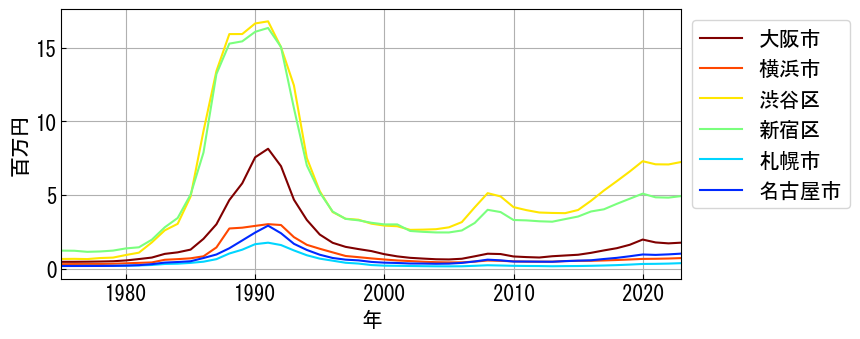

In [253]:
mypyplot(df_p['商業'][city], color=1, linestyle=0, xlab='年', ylab='百万円', figsize=(8, 3.5))

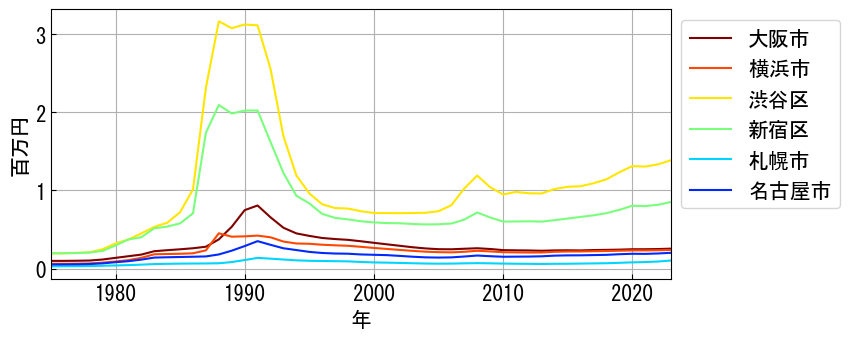

In [254]:
mypyplot(df_p['住宅'][city], color=1, linestyle=0, xlab='年', ylab='百万円', figsize=(8, 3.5))

In [248]:
##### 変動率推移表 #####
##### DATA PROCESSING #####
df_f = pd.read_excel(datapath, sheet_name=1, index_col=[2,1])  # sheet 1
df_f = df_f.drop(df_f.index[[0]], axis=0)  # Drop 1st index
df_f = df_f.drop(df_f.columns[[0]], axis=1)  # Drop 1st column
df_f = df_f.T
new_index = pd.Series(df_f.index).apply(wareki2western)  # apply the function to the DataFrame index
df_f.index = new_index  # assign the new index to the DataFrame


In [249]:
df_f.iloc[0, :] = 0  # normalize to the oldest data
df_f_s = df_f.cumsum()  # cumlative sum

In [250]:
df_f_s

住宅     宅見     商業     準工    工業    調区    全用途     住宅     宅見     商業  ...  \
         全国     全国     全国     全国    全国    全国     全国  三大都市圏  三大都市圏  三大都市圏  ...   
1975      0      0      0      0     0     0      0      0      0      0  ...   
1976    0.8    0.5    0.1    0.4   0.1  -0.4    0.5    0.6    0.2    0.1  ...   
1977    2.7    2.1    0.9    1.8   0.8   0.0    2.0    2.4    1.4    0.8  ...   
1978    6.0    5.0    2.2    4.2   1.8   0.9    4.5    5.8    4.2    2.1  ...   
1979   12.5   10.8    5.3    9.5   4.5   3.4    9.7   13.9   10.2    6.2  ...   
1980   25.2   22.2   12.1   19.9  10.7   8.4   20.1   30.4   23.7   15.8  ...   
1981   36.9   33.1   18.8   29.8  17.2  14.2   30.1   43.8   35.4   23.8  ...   
1982   45.2   41.3   24.6   37.2  22.7  19.5   37.5   51.9   43.2   29.8  ...   
1983   50.3   46.5   28.6   41.9  26.4  23.5   42.2   56.4   47.8   33.8  ...   
1984   53.3   49.5   32.1   44.9  28.7  26.0   45.2   59.0   50.5   38.3  ...   
1985   55.5   51.6   35.9   47.3  30.5  27.7   47.6   61.0   52.3   44.1  ...   
1986   57.7   53.2   41.0   49.6  32.2  29.0   50.2   63.7   53.9   53.3  ...   
1987   65.3   54.7   54.4   55.6  35.0  30.2   57.9   77.4   56.1   83.4  ...   
1988   90.3   66.9   76.3   74.1  45.4  35.0   79.6  124.0   81.7  130.0  ...   
1989   98.2   76.9   86.6   85.7  54.7  40.5   87.9  135.0   98.0  144.1  ...   
1990  115.2   96.8  103.3  106.9  69.9  52.2  104.5  157.0  129.3  162.7  ...   
1991  125.9  109.9  116.2  120.6  83.4  63.0  115.8  165.0  142.2  170.8  ...   
1992  120.3  108.3  112.2  116.7  83.0  63.4  111.2  152.5  134.9  160.5  ...   
1993  111.6  105.1  100.8  108.8  78.3  61.4  102.8  138.0  125.1  141.3  ...   
1994  106.9  103.9   89.5  103.3  74.6  60.5   97.2  130.7  120.7  124.1  ...   
1995  105.3  103.9   79.5  100.2  72.3  60.4   94.2  127.9  118.7  109.3  ...   
1996  102.7  103.2   69.7   96.1  68.7  59.8   90.2  123.3  115.2   93.3  ...   
1997  101.1  102.6   61.9   93.1  65.9  59.5   87.3  120.5  112.4   81.8  ...   
1998   99.7  102.2   55.8   90.6  63.5  59.1   84.9  118.3  110.5   74.3  ...   
1999   95.9   99.7   47.7   85.6  59.2  57.5   80.3  112.6  105.1   64.1  ...   
2000   91.8   96.8   39.7   80.2  54.2  55.4   75.4  106.7   99.1   54.5  ...   
2001   87.6   93.2   32.2   74.7  48.7  52.9   70.5  101.1   92.2   46.2  ...   
2002   82.4   87.9   23.9   68.1  41.3  48.9   64.6   94.6   83.5   37.7  ...   
2003   76.6   80.9   15.9   61.0  32.8  44.0   58.2   88.1   73.2   30.6  ...   
2004   70.9   72.5    8.5   54.1  24.1  38.5   52.0   82.4   62.2   24.8  ...   
2005   66.3   64.5    2.9   48.6  16.7  33.2   47.0   78.7   52.8   21.6  ...   
2006   63.6   58.2    0.2   45.4  11.8  29.1   44.2   77.5   47.3   22.6  ...   
2007   63.7   53.9    2.5   45.6  10.0  26.4   44.6   80.3   45.4   31.5  ...   
2008   65.0   50.9    6.3   47.1  10.5  24.6   46.3   84.6   44.8   41.9  ...   
2009   61.8   46.3    1.6   43.9   7.5  21.9   42.8   81.1   41.2   36.5  ...   
2010   57.6   40.8   -4.5   39.4   3.3  18.2   38.2   76.6   36.8   29.4  ...   
2011   54.9   35.9   -8.3   36.5   0.1  15.0   35.2   74.8   33.7   26.9  ...   
2012   52.6   31.2  -11.4   34.1  -3.1  11.9   32.6   73.5   30.6   25.3  ...   
2013   51.0   27.8  -13.5    NaN  -5.3   NaN   30.8   72.9   28.0   24.8  ...   
2014   50.4    NaN  -14.0    NaN  -6.4   NaN   30.2   73.4    NaN   26.4  ...   
2015   50.0    NaN  -14.0    NaN  -7.0   NaN   29.9   73.8    NaN   28.2  ...   
2016   49.8    NaN  -13.1    NaN  -7.0   NaN   30.0   74.3    NaN   31.1  ...   
2017   49.8    NaN  -11.7    NaN  -6.7   NaN   30.4   74.8    NaN   34.4  ...   
2018   50.1   27.4   -9.8    NaN  -5.9   NaN   31.1   75.5   27.2   38.3  ...   
2019   50.7   27.1   -7.0    NaN  -4.6   NaN   32.3   76.5   26.7   43.4  ...   
2020   51.5   27.0   -3.9    NaN  -2.8   NaN   33.7   77.6   26.2   48.8  ...   
2021   51.1   26.4   -4.7    NaN  -2.0   NaN   33.2   77.0   25.3   47.5  ...   
2022   51.6   26.2   -4.3    NaN   0.0  

#### 変動率

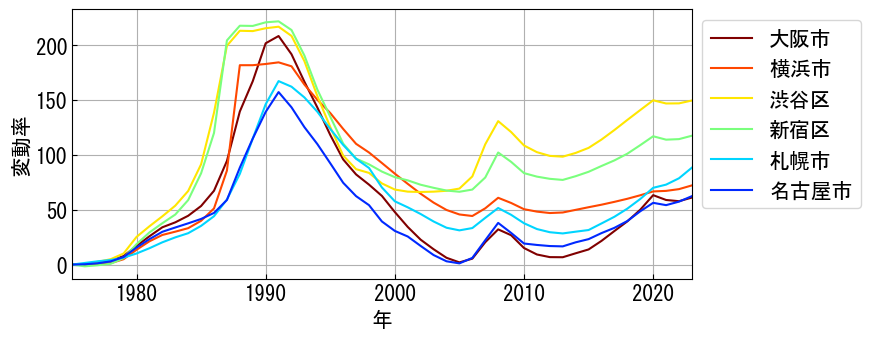

In [255]:
mypyplot(df_f_s['商業'][city], color=1, linestyle=0, xlab='年', ylab='変動率', figsize=(8, 3.5))

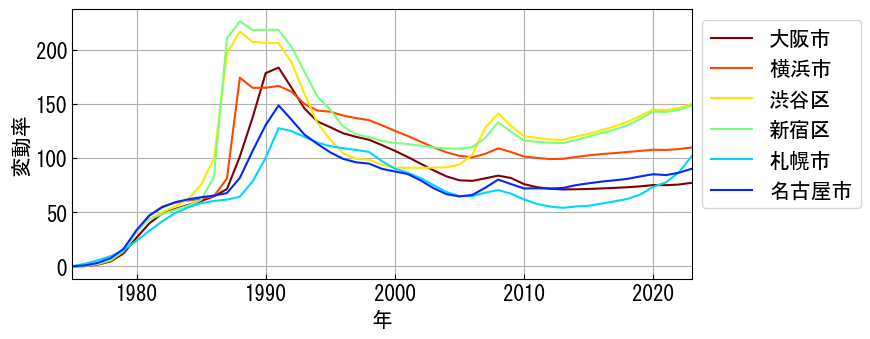

In [256]:
mypyplot(df_f_s['住宅'][city], color=1, linestyle=0, xlab='年', ylab='変動率', figsize=(8, 3.5))

### 不動産取引価格-大阪

REFERENCES:  
https://qiita.com/c60evaporator/items/ac6a6d66a20520f129e6  
https://qiita.com/c60evaporator/items/78b4148bac6afa4844f9#%E4%BD%BF%E7%94%A8%E3%81%99%E3%82%8B%E3%83%87%E3%83%BC%E3%82%BF  
https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03-v3_1.html

In [7]:
##### SETTINGS #####

# RealState data
filedir = r"C:\Users\A\Desktop\pythonProject\RealEstateProject\DATA\TXN HISTORY\ohsaka"
filedir_exp = filedir
filename = '27_Osaka Prefecture_20224_20224.csv'
datapath = filedir + '\\' + filename

# 市区町村のshapeデータ
geofile = r"C:\Users\A\Desktop\pythonProject\RealEstateProject\DATA\GEO\ohsaka\N03-20220101_27_GML\N03-22_27_220101.geojson"
gdf = gpd.read_file(geofile, encoding='SHIFT-JIS')
gdf = gdf[gdf['N03_003'] == '大阪市']
gdf = gdf.reset_index(drop=True)  # drop: drops current index
# 市区町村の重心を取得
gdf['centroid'] = gdf['geometry'].centroid
gdf["x"] = gdf.centroid.x
gdf["y"] = gdf.centroid.y

C:\Users\A\AppData\Local\Temp\ipykernel_1700\2437544638.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid
C:\Users\A\AppData\Local\Temp\ipykernel_1700\2437544638.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["x"] = gdf.centroid.x
C:\Users\A\AppData\Local\Temp\ipykernel_1700\2437544638.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["y"] = gdf.centroid.y


N03_001  N03_002 N03_003 N03_004 N03_007  \
0      大阪府      NaN     大阪市     都島区   27102   
1      大阪府      NaN     大阪市     福島区   27103   
2      大阪府      NaN     大阪市     此花区   27104   
3      大阪府      NaN     大阪市     此花区   27104   
4      大阪府      NaN     大阪市     此花区   27104   
5      大阪府      NaN     大阪市     此花区   27104   
6      大阪府      NaN     大阪市     此花区   27104   
7      大阪府      NaN     大阪市     此花区   27104   
8      大阪府      NaN     大阪市     此花区   27104   
9      大阪府      NaN     大阪市     此花区   27104   
10     大阪府      NaN     大阪市     此花区   27104   
11     大阪府      NaN     大阪市      西区   27106   
12     大阪府      NaN     大阪市      港区   27107   
13     大阪府      NaN     大阪市      港区   27107   
14     大阪府      NaN     大阪市      港区   27107   
15     大阪府      NaN     大阪市     大正区   27108   
16     大阪府      NaN     大阪市     大正区   27108   
17     大阪府      NaN     大阪市    天王寺区   27109   
18     大阪府      NaN     大阪市     浪速区   27111   
19     大阪府      NaN     大阪市    西淀川区   27113   
20     大阪府      NaN     大阪市    東淀川区   27114   
21     大阪府      NaN     大阪市     東成区   27115   
22     大阪府      NaN     大阪市     生野区   27116   
23     大阪府      NaN     大阪市      旭区   27117   
24     大阪府      NaN     大阪市     城東区   27118   
25     大阪府      NaN     大阪市    阿倍野区   27119   
26     大阪府      NaN     大阪市     住吉区   27120   
27     大阪府      NaN     大阪市    東住吉区   27121   
28     大阪府      NaN     大阪市     西成区   27122   
29     大阪府      NaN     大阪市     淀川区   27123   
30     大阪府      NaN     大阪市     鶴見区   27124   
31     大阪府      NaN     大阪市    住之江区   27125   
32     大阪府      NaN     大阪市    住之江区   27125   
33     大阪府      NaN     大阪市    住之江区   27125   
34     大阪府      NaN     大阪市    住之江区   27125   
35     大阪府      NaN     大阪市    住之江区   27125   
36     大阪府      NaN     大阪市     平野区   27126   
37     大阪府      NaN     大阪市      北区   27127   
38     大阪府      NaN     大阪市     中央区   27128   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [312]:
##### DATA PROCESSING #####

# RealState data
df = pd.read_csv(datapath, encoding="cp932")  # sheet 2
# df = df_p.drop(df_p.columns[[0]], axis=1)  # Drop 1st column

# mask data
# 大阪市.*区
mask = df[['市区町村名']].apply(lambda x: x.str.contains('大阪市.*区', regex=True)).any(axis=1)  # https://stackoverflow.com/questions/32614357/search-and-filter-pandas-dataframe-with-regular-expressions
df = df[mask]
# str2int
df['面積（㎡）'] = df['面積（㎡）'].apply(str2int)  # str2int
# df['面積（㎡）'] < 80
df = df.loc[df['面積（㎡）'] < 80]
# wareki2western
df['建築年'] = df['建築年'].apply(wareki2western)  # wareki2western
# count
df_p = df.groupby('市区町村名').count()
# sorting
order = df_p['No'].sort_values(ascending=False).index
df['市区町村名'] = pd.Categorical(df['市区町村名'], categories=order, ordered=True)
df.sort_values(by='市区町村名', inplace=True)
df = df.reset_index(drop=True)  # drop: drops current index

㎡以上: 2000
year is none of "令和" , "平成" and "昭和" 戦前
year is none of "令和" , "平成" and "昭和" 戦前
year is none of "令和" , "平成" and "昭和" 戦前


In [308]:
df

No         種類   地域  市区町村コード 都道府県名   市区町村名   地区名      最寄駅：名称 最寄駅：距離（分）  \
384  317   中古マンション等  NaN    27111   大阪府  大阪市浪速区   敷津東         大国町         2   
385  308   中古マンション等  NaN    27111   大阪府  大阪市浪速区    幸町      大正(大阪)         4   
386  307   中古マンション等  NaN    27111   大阪府  大阪市浪速区    幸町        ＪＲ難波         4   
387  306   中古マンション等  NaN    27111   大阪府  大阪市浪速区    幸町      桜川(大阪)         6   
388  305   中古マンション等  NaN    27111   大阪府  大阪市浪速区    幸町      桜川(大阪)         3   
389  304   中古マンション等  NaN    27111   大阪府  大阪市浪速区    幸町      桜川(大阪)         2   
390  303   中古マンション等  NaN    27111   大阪府  大阪市浪速区    幸町      桜川(大阪)         2   
391  302   中古マンション等  NaN    27111   大阪府  大阪市浪速区    幸町      桜川(大阪)         6   
392  301   中古マンション等  NaN    27111   大阪府  大阪市浪速区    幸町      桜川(大阪)         1   
393  310   中古マンション等  NaN    27111   大阪府  大阪市浪速区    桜川      桜川(大阪)         6   
394  298   中古マンション等  NaN    27111   大阪府  大阪市浪速区   戎本町         大国町         3   
395  296   中古マンション等  NaN    27111   大阪府  大阪市浪速区   戎本町         新今宮         2   
396  295   中古マンション等  NaN    27111   大阪府  大阪市浪速区  恵美須西         新今宮         4   
397  294   中古マンション等  NaN    27111   大阪府  大阪市浪速区  恵美須西         新今宮         4   
398  292   中古マンション等  NaN    27111   大阪府  大阪市浪速区    芦原         芦原橋         7   
399  291   中古マンション等  NaN    27111   大阪府  大阪市浪速区    芦原         芦原橋         7   
400  290   中古マンション等  NaN    27111   大阪府  大阪市浪速区    芦原         芦原橋         7   
401  289   中古マンション等  NaN    27111   大阪府  大阪市浪速区    芦原         芦原橋         7   
402  288   中古マンション等  NaN    27111   大阪府  大阪市浪速区    芦原         芦原橋         7   
403  297   中古マンション等  NaN    27111   大阪府  大阪市浪速区   戎本町         大国町         3   
404  311   中古マンション等  NaN    27111   大阪府  大阪市浪速区    桜川      桜川(大阪)         2   
405  300   中古マンション等  NaN    27111   大阪府  大阪市浪速区    幸町      桜川(大阪)         6   
406  314   中古マンション等  NaN    27111   大阪府  大阪市浪速区    塩草         芦原橋         6   
407  312   中古マンション等  NaN    27111   大阪府  大阪市浪速区    桜川        ＪＲ難波         4   
408  330   中古マンション等  NaN    27111   大阪府  大阪市浪速区  日本橋西  なんば(大阪メトロ)         8   
409  331   中古マンション等  NaN    27111   大阪府  大阪市浪速区  日本橋西      難波(南海)         6   
410  332   中古マンション等  NaN    27111   大阪府  大阪市浪速区  日本橋西      難波(南海)         6   
411  333   中古マンション等  NaN    27111   大阪府  大阪市浪速区  日本橋西      難波(南海)         6   
412  338   中古マンション等  NaN    27111   大阪府  大阪市浪速区    湊町  なんば(大阪メトロ)         5   
413  340   中古マンション等  NaN    27111   大阪府  大阪市浪速区    元町  なんば(大阪メトロ)         4   
414  341   中古マンション等  NaN    27111   大阪府  大阪市浪速区    元町  なんば(大阪メトロ)         4   
415  329   中古マンション等  NaN    27111   大阪府  大阪市浪速区   日本橋  なんば(大阪メトロ)         8   
416  339   中古マンション等  NaN    27111   大阪府  大阪市浪速区    元町  なんば(大阪メトロ)         4   
417  319   中古マンション等  NaN    27111   大阪府  大阪市浪速区    下寺        恵美須町         7   
418  326   中古マンション等  NaN    27111   大阪府  大阪市浪速区   難波中      難波(南海)         2   
419  325   中古マンション等  NaN    27111   大阪府  大阪市浪速区   難波中         大国町         5   
420  323   中古マンション等  NaN    27111   大阪府  大阪市浪速区    大国         大国町         1   
421  322   中古マンション等  NaN    27111   大阪府  大阪市浪速区    大国         大国町         3   
422  321  宅地(土地と建物)  住宅地    27111   大阪府  大阪市浪速区    大国          今宮         2   
423  320   中古マンション等  NaN    27111   大阪府  大阪市浪速区    下寺        恵美須町         7   
424  328   中古マンション等  NaN    27111   大阪府  大阪市浪速区   日本橋        恵美須町         1   
425  318   中古マンション等  NaN    27111   大阪府  大阪市浪速区   敷津東         大国町         2   

     取引価格（総額）  ...  今後の利用目的 前面道路：方位  前面道路：種類  前面道路：幅員（ｍ）     都市計画 建ぺい率（％）  \
384  23000000  ...       住宅     NaN      NaN         NaN     商業地域    80.0   
385  17000000  ...       住宅     NaN      NaN         NaN     商業地域    80.0   
386  12000000  ...       住宅     NaN      NaN         NaN     商業地域    80.0   
387  13000000  ...       住宅     NaN      NaN         NaN     商業地域    80.0   
388  29000000  ...       住宅     NaN      NaN         NaN     商業地域    80.0   
389  34000000  ...       住宅     NaN      NaN         NaN     商業地域    80.0   
390  16000000  ...       住宅     NaN      NaN         NaN     商業地域    

In [130]:
df.describe()

No       市区町村コード      取引価格（総額）           坪単価       面積（㎡）  \
count   829.000000    829.000000  8.290000e+02  4.000000e+01  829.000000   
mean    540.068758  27116.932449  2.245384e+07  1.070150e+06   44.439083   
std     319.716419      8.759827  1.771172e+07  1.069005e+06   19.731414   
min       2.000000  27102.000000  2.000000e+05  4.600000e+04   15.000000   
25%     256.000000  27108.000000  1.400000e+07  6.175000e+05   25.000000   
50%     535.000000  27118.000000  1.800000e+07  8.650000e+05   50.000000   
75%     827.000000  27125.000000  2.700000e+07  1.100000e+06   60.000000   
max    1074.000000  27128.000000  2.000000e+08  6.300000e+06   75.000000   

          取引価格（㎡単価）          建築年  前面道路：幅員（ｍ）     建ぺい率（％）       容積率（％）  
count  4.000000e+01   754.000000  192.000000  829.000000   829.000000  
mean   3.234250e+05  1999.787798    6.189063   76.043426   397.828709  
std    3.197730e+05    16.518654    4.580477    7.972055   186.876473  
min    1.400000e+04  1947.000000    1.700000   60.000000   200.000000  
25%    1.850000e+05  1986.000000    4.000000   80.000000   300.000000  
50%    2.600000e+05  2004.000000    5.000000   80.000000   400.000000  
75%    3.325000e+05  2014.000000    6.525000   80.000000   600.000000  
max    1.900000e+06  2023.000000   27.000000   80.000000  1000.000000

In [163]:
gdf

N03_001  N03_002 N03_003 N03_004 N03_007  \
0      大阪府      NaN     大阪市     都島区   27102   
1      大阪府      NaN     大阪市     福島区   27103   
2      大阪府      NaN     大阪市     此花区   27104   
3      大阪府      NaN     大阪市     此花区   27104   
4      大阪府      NaN     大阪市     此花区   27104   
5      大阪府      NaN     大阪市     此花区   27104   
6      大阪府      NaN     大阪市     此花区   27104   
7      大阪府      NaN     大阪市     此花区   27104   
8      大阪府      NaN     大阪市     此花区   27104   
9      大阪府      NaN     大阪市     此花区   27104   
10     大阪府      NaN     大阪市     此花区   27104   
11     大阪府      NaN     大阪市      西区   27106   
12     大阪府      NaN     大阪市      港区   27107   
13     大阪府      NaN     大阪市      港区   27107   
14     大阪府      NaN     大阪市      港区   27107   
15     大阪府      NaN     大阪市     大正区   27108   
16     大阪府      NaN     大阪市     大正区   27108   
17     大阪府      NaN     大阪市    天王寺区   27109   
18     大阪府      NaN     大阪市     浪速区   27111   
19     大阪府      NaN     大阪市    西淀川区   27113   
20     大阪府      NaN     大阪市    東淀川区   27114   
21     大阪府      NaN     大阪市     東成区   27115   
22     大阪府      NaN     大阪市     生野区   27116   
23     大阪府      NaN     大阪市      旭区   27117   
24     大阪府      NaN     大阪市     城東区   27118   
25     大阪府      NaN     大阪市    阿倍野区   27119   
26     大阪府      NaN     大阪市     住吉区   27120   
27     大阪府      NaN     大阪市    東住吉区   27121   
28     大阪府      NaN     大阪市     西成区   27122   
29     大阪府      NaN     大阪市     淀川区   27123   
30     大阪府      NaN     大阪市     鶴見区   27124   
31     大阪府      NaN     大阪市    住之江区   27125   
32     大阪府      NaN     大阪市    住之江区   27125   
33     大阪府      NaN     大阪市    住之江区   27125   
34     大阪府      NaN     大阪市    住之江区   27125   
35     大阪府      NaN     大阪市    住之江区   27125   
36     大阪府      NaN     大阪市     平野区   27126   
37     大阪府      NaN     大阪市      北区   27127   
38     大阪府      NaN     大阪市     中央区   27128   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

#### geopandas

In [164]:
# Make data for colormap
# Create gdf['count'] RealEstate data
arr = []
for i in range(len(gdf)):
    print("gdf['N03_003'][" + str(i) + ']:', gdf['N03_003'][i], ',', "gdf['N03_004'][" + str(i) + ']:', gdf['N03_004'][i])
    
    if gdf['N03_003'].isna()[i] and gdf['N03_004'].isna()[i]:
        print("gdf['N03_003'].isna()["+str(i)+"] == True and gdf['N03_004'].isna()["+str(i)+"] == True")
        arr.append(0)
    elif gdf['N03_003'].isna()[i]:
        print("gdf['N03_003'].isna()["+str(i)+"] == True")
        arr.append(df_p.loc[gdf['N03_004'][i]]['No'])
    elif gdf['N03_004'].isna()[i]:
        print("gdf['N03_004'].isna()["+str(i)+"] == True")
    else:
        arr.append(df_p.loc[gdf['N03_003'][i] + gdf['N03_004'][i]]['No'])
# Create a new column
gdf['count'] = arr
# 色を描画
num_color, cmap, norm = colors_scale(gdf['count'])

gdf['N03_003'][0]: 大阪市 , gdf['N03_004'][0]: 都島区
gdf['N03_003'][1]: 大阪市 , gdf['N03_004'][1]: 福島区
gdf['N03_003'][2]: 大阪市 , gdf['N03_004'][2]: 此花区
gdf['N03_003'][3]: 大阪市 , gdf['N03_004'][3]: 此花区
gdf['N03_003'][4]: 大阪市 , gdf['N03_004'][4]: 此花区
gdf['N03_003'][5]: 大阪市 , gdf['N03_004'][5]: 此花区
gdf['N03_003'][6]: 大阪市 , gdf['N03_004'][6]: 此花区
gdf['N03_003'][7]: 大阪市 , gdf['N03_004'][7]: 此花区
gdf['N03_003'][8]: 大阪市 , gdf['N03_004'][8]: 此花区
gdf['N03_003'][9]: 大阪市 , gdf['N03_004'][9]: 此花区
gdf['N03_003'][10]: 大阪市 , gdf['N03_004'][10]: 此花区
gdf['N03_003'][11]: 大阪市 , gdf['N03_004'][11]: 西区
gdf['N03_003'][12]: 大阪市 , gdf['N03_004'][12]: 港区
gdf['N03_003'][13]: 大阪市 , gdf['N03_004'][13]: 港区
gdf['N03_003'][14]: 大阪市 , gdf['N03_004'][14]: 港区
gdf['N03_003'][15]: 大阪市 , gdf['N03_004'][15]: 大正区
gdf['N03_003'][16]: 大阪市 , gdf['N03_004'][16]: 大正区
gdf['N03_003'][17]: 大阪市 , gdf['N03_004'][17]: 天王寺区
gdf['N03_003'][18]: 大阪市 , gdf['N03_004'][18]: 浪速区
gdf['N03_003'][19]: 大阪市 , gdf['N03_004'][19]: 西淀川区
gdf['N03_003'][20]: 大阪

C:\Users\A\AppData\Local\Temp\ipykernel_27336\1018667993.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  name_df = gdf.groupby(['N03_003', 'N03_004'], dropna=False, as_index=False).mean().loc[:, ['N03_003', 'N03_004', 'x', 'y']]


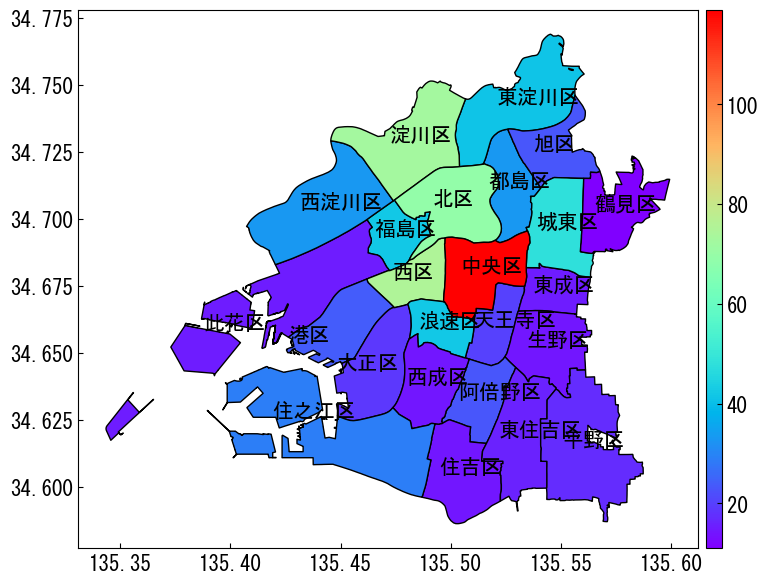

In [165]:
##### PLOT #####
fig, ax = plt.subplots(1, 1, figsize=(8, 8))


# gdf.plot
base = gdf.plot(ax=ax, color=num_color, edgecolor='black')  # 

# 市町村名をプロット
# Extract cordinates
name_df = gdf.groupby(['N03_003', 'N03_004'], dropna=False, as_index=False).mean().loc[:, ['N03_003', 'N03_004', 'x', 'y']]
name_df.drop(name_df[name_df['N03_004'].isna()].index)  # drop NaN
# Loop for the length of name_df
mylist = list(name_df.index)
for l in mylist:
    plt.text(name_df['x'][l]-0.01, name_df['y'][l], name_df['N03_004'][l], fontname="MS Gothic", fontsize=15)

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cax = fig.add_axes([base.get_position().x1+0.01, base.get_position().y0, 0.02, base.get_position().height])
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params()


#### Scatter plot

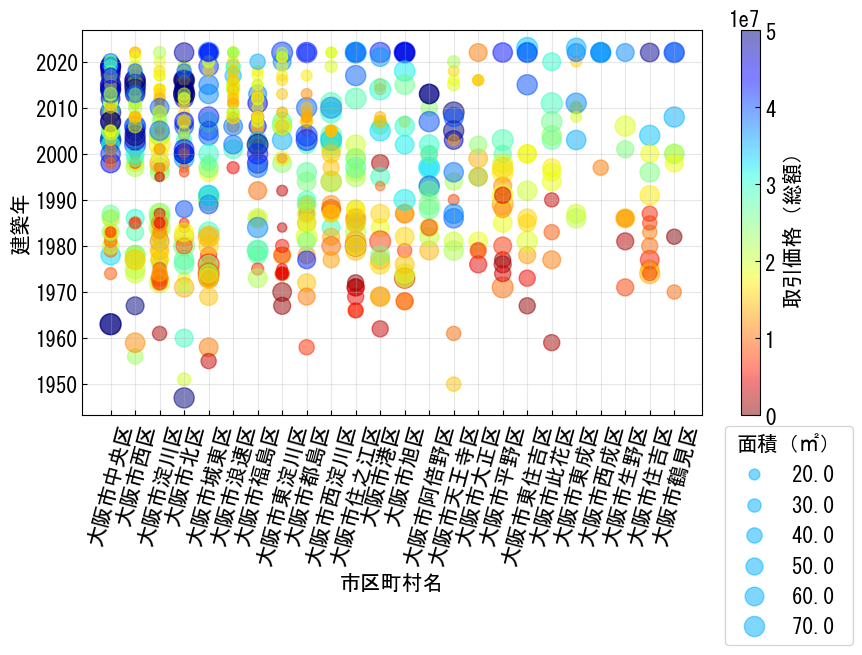

In [166]:
fig, ax = plt.subplots(figsize=(10, 5))
# scatter plot
x=df['市区町村名']
y=df['建築年']
c=df['取引価格（総額）']
s=df['面積（㎡）'] * 3
scatter = ax.scatter(x=x, y=y, c=c, s=s, cmap='jet_r', vmin=0, vmax=50_000_000, alpha=.5)

# settings
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.grid(True, alpha=.3)
plt.xticks(rotation=75)
# plot size
kw = dict(prop="sizes", num=5, color=scatter.cmap(0.7), fmt="{x} ", func=lambda s: s/3)  # https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
ax.legend(*scatter.legend_elements(**kw), bbox_to_anchor=(1.02, 0), loc="upper left", title=s.name)
# colorbar
plt.colorbar(scatter, label=c.name)

#### Bar Plot

In [295]:
df_bar = df[['市区町村名', '都市計画', '取引価格（総額）']]
df_bar

市区町村名          都市計画  取引価格（総額）
0    大阪市中央区          商業地域  45000000
1    大阪市中央区          商業地域  92000000
2    大阪市中央区          商業地域  86000000
3    大阪市中央区          商業地域  57000000
4    大阪市中央区          商業地域   8000000
..      ...           ...       ...
824  大阪市鶴見区       第１種住居地域  11000000
825  大阪市鶴見区         準住居地域  18000000
826  大阪市鶴見区  第２種中高層住居専用地域  38000000
827  大阪市鶴見区       第１種住居地域    200000
828  大阪市鶴見区         準工業地域  10000000

[829 rows x 3 columns]

In [298]:
df_bar_grp = df_bar.groupby(['市区町村名', '都市計画']).sum().unstack()
df_bar_grp

取引価格（総額）                                                          \
都市計画           商業地域       工業地域     準住居地域      準工業地域 第１種中高層住居専用地域    第１種住居地域   
市区町村名                                                                         
大阪市中央区   3566500000          0         0          0            0          0   
大阪市西区    1821000000          0         0   75000000            0          0   
大阪市淀川区    492000000   31000000  34000000  156000000     22000000  272000000   
大阪市北区    1425000000  142000000         0  368000000            0          0   
大阪市城東区     68000000   25000000  65000000  332800000            0  442500000   
大阪市浪速区    681800000          0         0  112000000            0          0   
大阪市福島区    433700000   71000000         0  104300000            0          0   
大阪市東淀川区   126300000   24000000  15000000  150000000            0  116500000   
大阪市都島区     91000000          0  69000000  107000000            0  322000000   
大阪市西淀川区    29000000  136000000  71000000  134000000            0  123500000   
大阪市住之江区    60000000   27000000  30000000  136900000     27000000   85400000   
大阪市港区     244500000          0         0  103000000            0   19400000   
大阪市旭区      15000000          0  23500000   32000000            0  157900000   
大阪市阿倍野区   279500000          0         0          0            0  108500000   
大阪市天王寺区   297000000          0  22000000          0            0          0   
大阪市大正区     81800000          0  11000000   96800000            0   37200000   
大阪市平野区     20700000   17000000         0   59000000            0  120800000   
大阪市東住吉区           0          0  29000000   54000000            0  137900000   
大阪市此花区     55000000          0         0  100400000            0   71000000   
大阪市東成区     88000000   35000000         0  123500000            0   59000000   
大阪市西成区     57000000          0         0  131000000            0   22000000   
大阪市生野区     11000000   23000000         0  104400000            0   53700000   
大阪市住吉区     83000000          0         0          0            0   49200000   
大阪市鶴見区            0          0  18000000   37000000     42000000  178200000   

                                           
都市計画    第２種中高層住居専用地域    第２種住居地域    近隣商業地域  
市区町村名                                      
大阪市中央区             0   31000000  34000000  
大阪市西区              0          0         0  
大阪市淀川区      59000000   32000000  54000000  
大阪市北区              0  185000000   7300000  
大阪市城東区      46000000    2500000  73200000  
大阪市浪速区             0   15000000         0  
大阪市福島区             0  330000000  28000000  
大阪市東淀川区    126400000   37000000  19000000  
大阪市都島区      73000000   16000000  27000000  
大阪市西淀川区            0          0  77000000  
大阪市住之江区     69700000          0  82500000  
大阪市港区       36000000   31000000         0  
大阪市旭区      239000000   15000000  30000000  
大阪市阿倍野区    138000000   33000000  53000000  
大阪市天王寺区            0  234800000  55000000  
大阪市大正区             0   11000000         0  
大阪市平野区      32200000          0   3600000  
大阪市東住吉区     57930000          0  20000000  
大阪市此花区             0   36000000         0  
大阪市東成区             0          0  35000000  
大阪市西成区      36000000          0  10000000  
大阪市生野区             0          0  17000000  
大阪市住吉区      98000000          0         0  
大阪市鶴見区      38000000          0         0

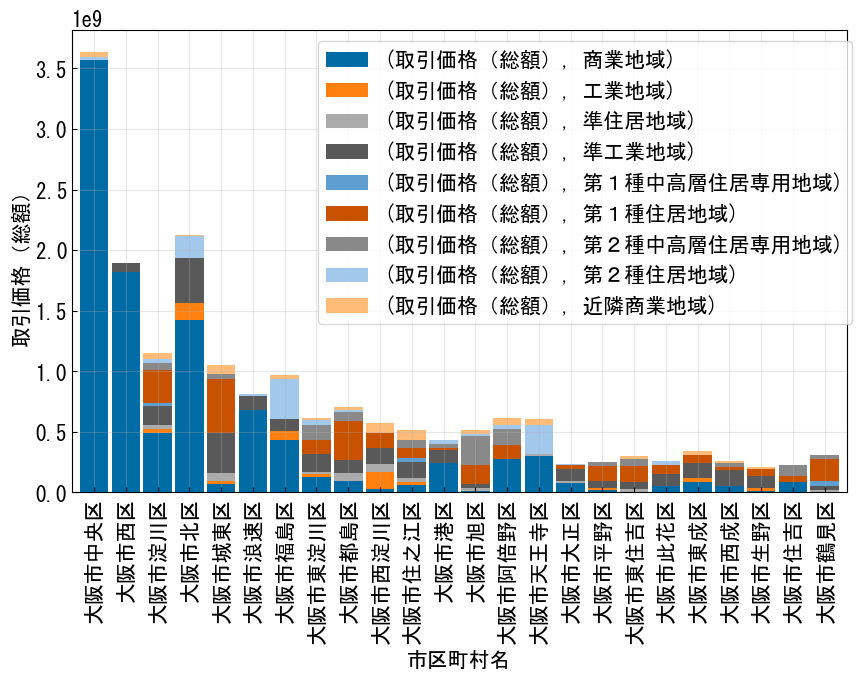

In [306]:
df_bar.groupby(['市区町村名', '都市計画']).sum().unstack().plot(kind='bar', stacked=True, figsize=(10,5), width=.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper right")
plt.xlabel(df_bar.columns[0])
plt.ylabel(df_bar.columns[-1])
plt.grid(True, alpha=.3)

#### 区単位

In [5]:
##### SETTINGS #####

# RealState data
filedir = r"C:\Users\A\Desktop\pythonProject\RealEstateProject\DATA\TXN HISTORY\ohsaka"
filedir_exp = filedir
filename = '27_Osaka Prefecture_20053_20224.csv'
datapath = filedir + '\\' + filename

In [23]:
##### DATA PROCESSING #####

# RealState data
df_raw = pd.read_csv(datapath, encoding="cp932")
# mask data
# 大阪市.*区
mask = df_raw[['市区町村名']].apply(lambda x: x.str.contains('大阪市浪速区')).any(axis=1)  # https://stackoverflow.com/questions/32614357/search-and-filter-pandas-dataframe-with-regular-expressions
df = df_raw[mask]
# str2int
df['取引時点'] = df['取引時点'].apply(str2int)
df['面積（㎡）'] = df['面積（㎡）'].apply(str2int)
# df['面積（㎡）'] < 80
df = df.loc[df['面積（㎡）'] < 80]
# wareki2western
df['建築年'] = df['建築年'].apply(wareki2western)  # wareki2western

㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
year is none of "令和" , "平成" and "昭和" 戦前


C:\Users\A\AppData\Local\Temp\ipykernel_19748\409288041.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['取引時点'] = df['取引時点'].apply(str2int)
C:\Users\A\AppData\Local\Temp\ipykernel_19748\409288041.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['面積（㎡）'] = df['面積（㎡）'].apply(str2int)


Text(0, 0.5, '建築年')

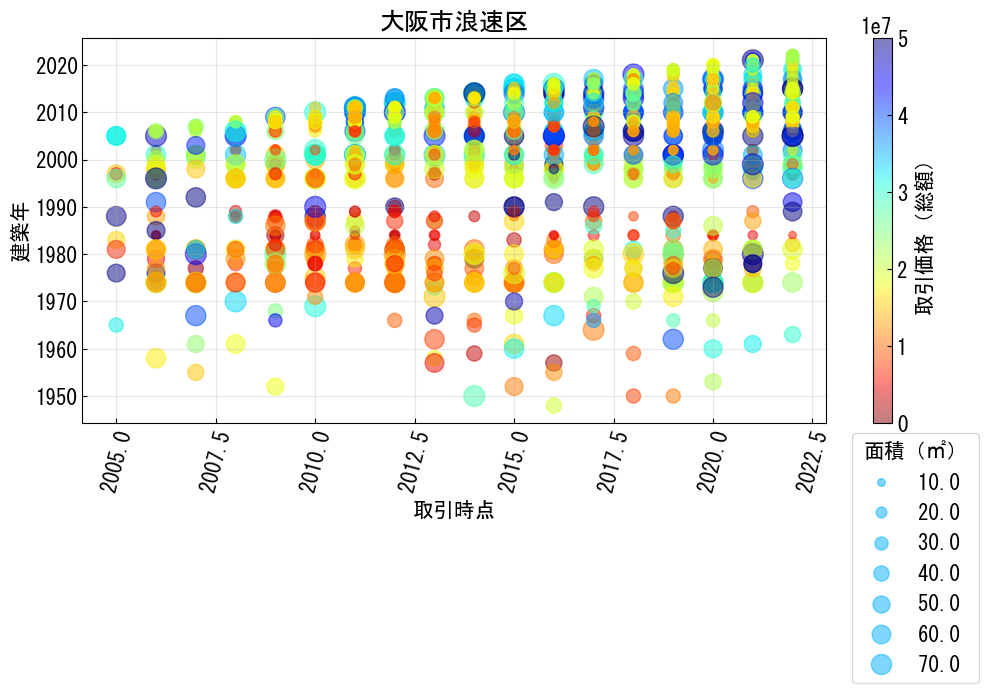

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.grid(True, alpha=.3)
plt.xticks(rotation=75)

# scatter plot
x=df['取引時点']
y=df['建築年']
c=df['取引価格（総額）']
s=df['面積（㎡）'] * 3
scatter = ax.scatter(x=x, y=y, c=c, s=s, cmap='jet_r', vmin=0, vmax=50_000_000, alpha=.5)

# plot size
kw = dict(prop="sizes", num=5, color=scatter.cmap(0.7), fmt="{x} ", func=lambda s: s/3)  # https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
ax.legend(*scatter.legend_elements(**kw), bbox_to_anchor=(1.02, 0), loc="upper left", title=s.name)
# colorbar
plt.colorbar(scatter, label=c.name)
# settings
plt.title(df['市区町村名'][0])
plt.xlabel(x.name)
plt.ylabel(y.name)

In [30]:
df_bar = df[['取引時点', '市区町村名', '都市計画', '取引価格（総額）']]
df_bar

取引時点   市区町村名   都市計画  取引価格（総額）
0     2022  大阪市浪速区  準工業地域  20000000
1     2015  大阪市浪速区   商業地域  11000000
2     2015  大阪市浪速区   商業地域  11000000
3     2015  大阪市浪速区  準工業地域   2800000
4     2015  大阪市浪速区   商業地域  13000000
...    ...     ...    ...       ...
2225  2022  大阪市浪速区   商業地域  19000000
2226  2022  大阪市浪速区   商業地域  18000000
2227  2021  大阪市浪速区   商業地域  18000000
2228  2022  大阪市浪速区   商業地域  30000000
2229  2005  大阪市浪速区    NaN   6500000

[2230 rows x 4 columns]

In [28]:
df_bar_grp = df_bar.groupby(['取引時点', '都市計画']).sum().unstack()
df_bar_grp

C:\Users\A\AppData\Local\Temp\ipykernel_19748\2447613595.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bar_grp = df_bar.groupby(['取引時点', '都市計画']).sum().unstack()


取引価格（総額）                                      
都市計画          商業地域       準住居地域        準工業地域      第２種住居地域
取引時点                                                    
2005  3.280000e+08         NaN          NaN          NaN
2006  7.360000e+08         NaN   59000000.0    2400000.0
2007  7.575000e+08         NaN  162000000.0          NaN
2008  6.080000e+08         NaN   69500000.0          NaN
2009  1.021500e+09         NaN   14000000.0          NaN
2010  1.170500e+09         NaN   14000000.0          NaN
2011  4.975900e+09         NaN  155300000.0          NaN
2012  1.236540e+09  27000000.0   84700000.0          NaN
2013  2.189500e+09  26000000.0  106500000.0   50000000.0
2014  1.724700e+09         NaN  113200000.0   24000000.0
2015  3.051200e+09         NaN   74900000.0   31000000.0
2016  3.226100e+09         NaN  149000000.0   40000000.0
2017  1.871300e+09  34000000.0  341300000.0   22300000.0
2018  1.901600e+09         NaN  188000000.0  104000000.0
2019  2.309600e+09  20000000.0  345000000.0  240000000.0
2020  3.340800e+09  91000000.0  477900000.0   57000000.0
2021  3.385900e+09  33000000.0  360000000.0   54000000.0
2022  3.614900e+09         NaN  632000000.0   32000000.0

C:\Users\A\AppData\Local\Temp\ipykernel_19748\2546299999.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bar.groupby(['取引時点', '都市計画']).sum().unstack().plot(kind='bar', stacked=True, figsize=(10,5), width=.9)


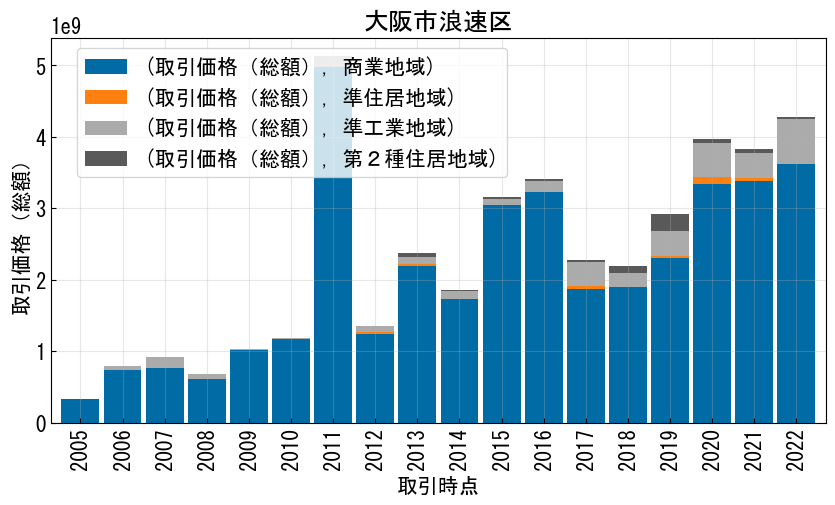

In [35]:
df_bar.groupby(['取引時点', '都市計画']).sum().unstack().plot(kind='bar', stacked=True, figsize=(10,5), width=.9)
plt.legend(bbox_to_anchor=(0.02, 1), loc="upper left")
plt.title(df_bar['市区町村名'][0])
plt.xlabel(df_bar.columns[0])
plt.ylabel(df_bar.columns[-1])
plt.grid(True, alpha=.3)

C:\Users\A\AppData\Local\Temp\ipykernel_19748\412317260.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bar2.groupby(['取引時点', '都市計画']).mean().unstack().plot(ax=ax)


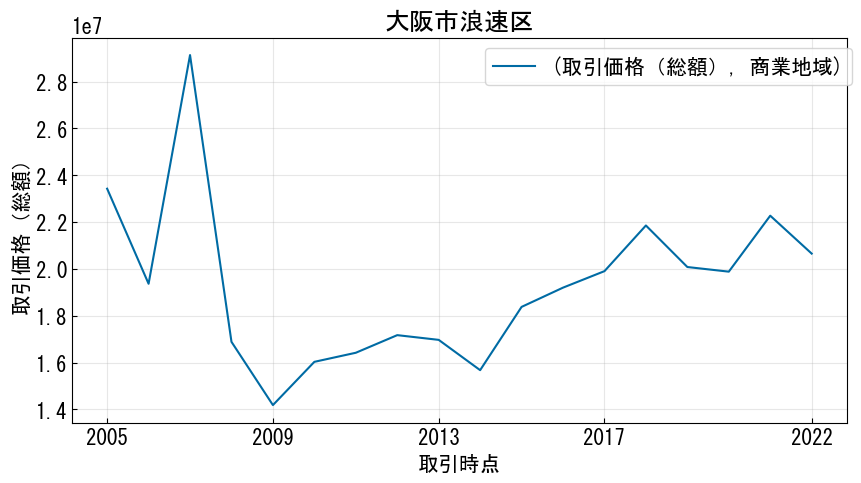

In [53]:
# 商業地域
mask = df_bar[['都市計画']].apply(lambda x: x.str.contains('商業地域')).any(axis=1)  # https://stackoverflow.com/questions/32614357/search-and-filter-pandas-dataframe-with-regular-expressions
df_bar2 = df_bar[mask]
# PLOT
fig, ax = plt.subplots(figsize=(10,5))
df_bar2.groupby(['取引時点', '都市計画']).mean().unstack().plot(ax=ax)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper right")
# SET UP
ax.set_xticks(np.linspace(df_bar['取引時点'].min(), df_bar['取引時点'].max(), 5).astype(int))
ax.grid(True, alpha=.3)
plt.title(df_bar['市区町村名'][0])
plt.xlabel(df_bar.columns[0])
plt.ylabel(df_bar.columns[-1])

In [50]:
##### DATA PROCESSING #####

# RealState data
df_raw = pd.read_csv(datapath, encoding="cp932")
df = df_raw[['取引時点', '市区町村名', '都市計画', '面積（㎡）', '取引価格（総額）']]
# MASK 0: 商業地域
mask = df[['都市計画']].apply(lambda x: x.str.contains('商業地域')).any(axis=1)
df = df[mask]
# MASK 1: 面積（㎡）
df['面積（㎡）'] = df['面積（㎡）'].apply(str2int)
mask = df[['面積（㎡）']].apply(lambda x: x<35).any(axis=1)
df = df[mask]
# MASK 2: 市区町村名
s = '大阪市中央区|大阪市西区|大阪市淀川区|大阪市北区|大阪市浪速区|大阪市福島区'
mask = df[['市区町村名']].apply(lambda x: x.str.contains(s, regex=True)).any(axis=1)
df = df[mask]
df = df[['取引時点', '市区町村名', '都市計画', '取引価格（総額）']]
# str2int
df['取引時点'] = df.loc[:, '取引時点'].apply(str2int)


# # Process df
# def process_df(name):

#     # mask data
#     # 大阪市.*区
#     mask = df_raw[['市区町村名']].apply(lambda x: x.str.contains(name)).any(axis=1)  # https://stackoverflow.com/questions/32614357/search-and-filter-pandas-dataframe-with-regular-expressions
#     df = df_raw[mask]
#     # str2int
#     df['取引時点'] = df.loc[:, '取引時点'].apply(str2int)
#     # wareki2western
#     df['建築年'] = df.loc[:, '建築年'].apply(wareki2western)  # wareki2western
    
#     return df

# # 市区町村名
# lst = ['大阪市中央区', '大阪市西区', '大阪市淀川区', '大阪市北区', '大阪市浪速区', '大阪市福島区']
# dct = {}
# for i, name in enumerate(lst):
#     df_new = process_df(name)
#     df_new = df_new[['取引時点', '市区町村名', '都市計画', '取引価格（総額）']]
#     dct.update({i: df_new})

C:\Users\A\AppData\Local\Temp\ipykernel_19396\2447611954.py:4: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(datapath, encoding="cp932")


㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000


In [45]:
df

取引時点   市区町村名  都市計画  取引価格（総額）
1610    2022  大阪市福島区  商業地域  15000000
1617    2022  大阪市福島区  商業地域   7500000
1621    2022  大阪市福島区  商業地域  17000000
1623    2022  大阪市福島区  商業地域  15000000
1624    2022  大阪市福島区  商業地域  16000000
...      ...     ...   ...       ...
278839  2005  大阪市中央区  商業地域  34000000
278840  2005  大阪市中央区  商業地域   4100000
278848  2006  大阪市中央区  商業地域   9800000
278849  2006  大阪市中央区  商業地域   8500000
278853  2008  大阪市中央区  商業地域  11000000

[9589 rows x 4 columns]

Text(0, 0.5, '取引価格（総額）')

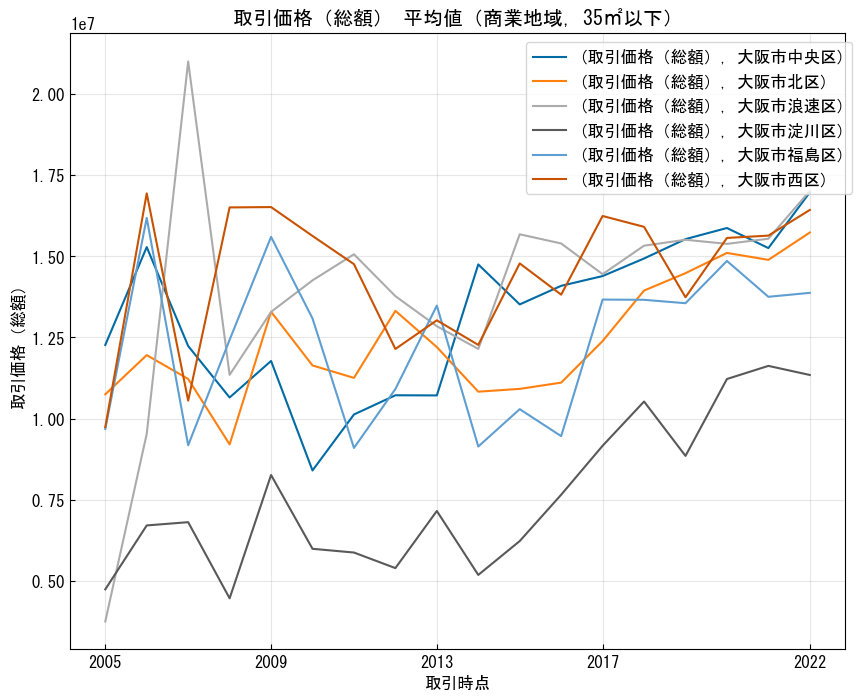

In [51]:
fig, ax = plt.subplots(figsize=(10,8))

# PLOT
df.groupby(['取引時点', '市区町村名']).mean(numeric_only=True).unstack().plot(ax=ax)
    
# SET UP
ax.set_xticks(np.linspace(df['取引時点'].min(), df['取引時点'].max(), 5).astype(int))
ax.grid(True, alpha=.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper right")
plt.title(df.columns[-1]+' 平均値（商業地域, 35㎡以下）')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[-1])

### 不動産取引価格-神奈川

In [18]:
##### SETTINGS #####

# RealState data
filedir = r"C:\Users\A\Desktop\pythonProject\RealEstateProject\DATA\TXN HISTORY\kanagawa"
filedir_exp = filedir
filename = '14_Kanagawa Prefecture_20221_20224.csv'
datapath = filedir + '\\' + filename

# 市区町村のshapeデータ
geofile = r"C:\Users\A\Desktop\pythonProject\RealEstateProject\DATA\GEO\kanagawa\N03-20230101_14_GML\N03-23_14_230101.geojson"
gdf = gpd.read_file(geofile, encoding='SHIFT-JIS')
gdf = gdf[gdf['N03_003'] == '横浜市']
gdf = gdf.reset_index(drop=True)  # drop: drops current index
# 市区町村の重心を取得
gdf['centroid'] = gdf['geometry'].centroid
gdf["x"] = gdf.centroid.x
gdf["y"] = gdf.centroid.y

C:\Users\A\AppData\Local\Temp\ipykernel_1700\3094528995.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid
C:\Users\A\AppData\Local\Temp\ipykernel_1700\3094528995.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["x"] = gdf.centroid.x
C:\Users\A\AppData\Local\Temp\ipykernel_1700\3094528995.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["y"] = gdf.centroid.y


In [19]:
gdf

N03_001  N03_002 N03_003   N03_004 N03_007  \
0      神奈川      NaN     横浜市    横浜市鶴見区   14101   
1      神奈川      NaN     横浜市    横浜市鶴見区   14101   
2      神奈川      NaN     横浜市    横浜市鶴見区   14101   
3      神奈川      NaN     横浜市    横浜市鶴見区   14101   
4      神奈川      NaN     横浜市    横浜市鶴見区   14101   
5      神奈川      NaN     横浜市    横浜市鶴見区   14101   
6      神奈川      NaN     横浜市    横浜市鶴見区   14101   
7      神奈川      NaN     横浜市    横浜市鶴見区   14101   
8      神奈川      NaN     横浜市   横浜市神奈川区   14102   
9      神奈川      NaN     横浜市   横浜市神奈川区   14102   
10     神奈川      NaN     横浜市   横浜市神奈川区   14102   
11     神奈川      NaN     横浜市   横浜市神奈川区   14102   
12     神奈川      NaN     横浜市   横浜市神奈川区   14102   
13     神奈川      NaN     横浜市     横浜市西区   14103   
14     神奈川      NaN     横浜市     横浜市中区   14104   
15     神奈川      NaN     横浜市     横浜市中区   14104   
16     神奈川      NaN     横浜市     横浜市中区   14104   
17     神奈川      NaN     横浜市     横浜市中区   14104   
18     神奈川      NaN     横浜市     横浜市中区   14104   
19     神奈川      NaN     横浜市     横浜市中区   14104   
20     神奈川      NaN     横浜市     横浜市中区   14104   
21     神奈川      NaN     横浜市     横浜市中区   14104   
22     神奈川      NaN     横浜市     横浜市中区   14104   
23     神奈川      NaN     横浜市     横浜市中区   14104   
24     神奈川      NaN     横浜市     横浜市中区   14104   
25     神奈川      NaN     横浜市     横浜市中区   14104   
26     神奈川      NaN     横浜市     横浜市中区   14104   
27     神奈川      NaN     横浜市     横浜市南区   14105   
28     神奈川      NaN     横浜市  横浜市保土ケ谷区   14106   
29     神奈川      NaN     横浜市    横浜市磯子区   14107   
30     神奈川      NaN     横浜市    横浜市磯子区   14107   
31     神奈川      NaN     横浜市    横浜市磯子区   14107   
32     神奈川      NaN     横浜市    横浜市金沢区   14108   
33     神奈川      NaN     横浜市    横浜市金沢区   14108   
34     神奈川      NaN     横浜市    横浜市金沢区   14108   
35     神奈川      NaN     横浜市    横浜市金沢区   14108   
36     神奈川      NaN     横浜市    横浜市金沢区   14108   
37     神奈川      NaN     横浜市    横浜市金沢区   14108   
38     神奈川      NaN     横浜市    横浜市金沢区   14108   
39     神奈川      NaN     横浜市    横浜市金沢区   14108   
40     神奈川      NaN     横浜市    横浜市金沢区   14108   
41     神奈川      NaN     横浜市    横浜市金沢区   14108   
42     神奈川      NaN     横浜市    横浜市金沢区   14108   
43     神奈川      NaN     横浜市    横浜市金沢区   14108   
44     神奈川      NaN     横浜市    横浜市金沢区   14108   
45     神奈川      NaN     横浜市    横浜市港北区   14109   
46     神奈川      NaN     横浜市    横浜市戸塚区   14110   
47     神奈川      NaN     横浜市    横浜市港南区   14111   
48     神奈川      NaN     横浜市     横浜市旭区   14112   
49     神奈川      NaN     横浜市     横浜市緑区   14113   
50     神奈川      NaN     横浜市    横浜市瀬谷区   14114   
51     神奈川      NaN     横浜市     横浜市栄区   14115   
52     神奈川      NaN     横浜市     横浜市泉区   14116   
53     神奈川      NaN     横浜市    横浜市青葉区   14117   
54     神奈川      NaN     横浜市    横浜市都筑区   14118   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [20]:
##### DATA PROCESSING #####

# RealState data
df = pd.read_csv(datapath, encoding="cp932")
# df = df_p.drop(df_p.columns[[0]], axis=1)  # Drop 1st column

# mask data
# 大阪市.*区
mask = df[['市区町村名']].apply(lambda x: x.str.contains('横浜市.*区', regex=True)).any(axis=1)  # https://stackoverflow.com/questions/32614357/search-and-filter-pandas-dataframe-with-regular-expressions
df = df[mask]
# str2int
df['面積（㎡）'] = df['面積（㎡）'].apply(str2int)  # str2int
# df['面積（㎡）'] < 80
df = df.loc[df['面積（㎡）'] < 80]
# wareki2western
df['建築年'] = df['建築年'].apply(wareki2western)  # wareki2western
# count
df_p = df.groupby('市区町村名').count()
# sorting
order = df_p['No'].sort_values(ascending=False).index
df['市区町村名'] = pd.Categorical(df['市区町村名'], categories=order, ordered=True)
df.sort_values(by='市区町村名', inplace=True)
df = df.reset_index(drop=True)  # drop: drops current index

㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000


In [21]:
df

No         種類   地域  市区町村コード 都道府県名   市区町村名   地区名  最寄駅：名称 最寄駅：距離（分）  \
0     1777   中古マンション等  NaN    14104  神奈川県   横浜市中区   山下町  元町・中華街         4   
1     1673   中古マンション等  NaN    14104  神奈川県   横浜市中区   本牧原      山手   30分?60分   
2     1672   中古マンション等  NaN    14104  神奈川県   横浜市中区   本牧原      山手   30分?60分   
3     1670   中古マンション等  NaN    14104  神奈川県   横浜市中区   本牧原      山手   30分?60分   
4     1669   中古マンション等  NaN    14104  神奈川県   横浜市中区   本牧原      山手   30分?60分   
...    ...        ...  ...      ...   ...     ...   ...     ...       ...   
3376  5879   中古マンション等  NaN    14114  神奈川県  横浜市瀬谷区   三ツ境     三ツ境         4   
3377  5889   中古マンション等  NaN    14114  神奈川県  横浜市瀬谷区   三ツ境     三ツ境        14   
3378  5892   中古マンション等  NaN    14114  神奈川県  横浜市瀬谷区    南台      瀬谷        18   
3379  5831  宅地(土地と建物)  住宅地    14114  神奈川県  横浜市瀬谷区  二ツ橋町     三ツ境         8   
3380  5783     宅地(土地)  住宅地    14114  神奈川県  横浜市瀬谷区   下瀬谷      瀬谷   30分?60分   

      取引価格（総額）  ...  今後の利用目的 前面道路：方位  前面道路：種類  前面道路：幅員（ｍ）          都市計画  \
0     43000000  ...       住宅     NaN      NaN         NaN          商業地域   
1     42000000  ...       住宅     NaN      NaN         NaN         準住居地域   
2     42000000  ...       住宅     NaN      NaN         NaN       第１種住居地域   
3     41000000  ...       住宅     NaN      NaN         NaN       第２種住居地域   
4     40000000  ...       住宅     NaN      NaN         NaN       第１種住居地域   
...        ...  ...      ...     ...      ...         ...           ...   
3376  36000000  ...       住宅     NaN      NaN         NaN        近隣商業地域   
3377  32000000  ...       住宅     NaN      NaN         NaN  第１種中高層住居専用地域   
3378  23000000  ...       住宅     NaN      NaN         NaN        近隣商業地域   
3379  40000000  ...       住宅      南西       市道         4.0       第１種住居地域   
3380  10000000  ...      その他      南東       市道         6.5   第１種低層住居専用地域   

     建ぺい率（％） 容積率（％）        取引時点   改装 取引の事情等  
0       80.0  500.0  2022年第１四半期  未改装    NaN  
1       60.0  200.0  2022年第１四半期  改装済    NaN  
2       60.0  200.0  2022年第１四半期  NaN    NaN  
3       60.0  200.0  2022年第３四半期  未改装    NaN  
4       60.0  200.0  2022年第３四半期  未改装    NaN  
...      ...    ...         ...  ...    ...  
3376    80.0  300.0  2022年第２四半期  改装済    NaN  
3377    60.0  150.0  2022年第１四半期  改装済    NaN  
3378     NaN    NaN  2022年第２四半期  改装済    NaN  
3379    60.0  200.0  2022年第４四半期  NaN    NaN  
3380    50.0   80.0  2022年第２四半期  NaN    NaN  

[3381 rows x 30 columns]

In [22]:
df.describe()

No       市区町村コード      取引価格（総額）           坪単価        面積（㎡）  \
count  3381.000000   3381.000000  3.381000e+03  1.180000e+02  3381.000000   
mean   2920.070393  14107.165336  2.790350e+07  1.293613e+06    50.224786   
std    1965.162268      4.795356  1.991933e+07  9.327616e+05    19.818176   
min       1.000000  14101.000000  1.000000e+03  5.200000e+01    10.000000   
25%    1254.000000  14103.000000  1.500000e+07  6.025000e+05    30.000000   
50%    2556.000000  14106.000000  2.500000e+07  1.100000e+06    55.000000   
75%    4468.000000  14110.000000  3.800000e+07  1.900000e+06    65.000000   
max    7015.000000  14118.000000  4.500000e+08  3.600000e+06    75.000000   

          取引価格（㎡単価）          建築年  前面道路：幅員（ｍ）      建ぺい率（％）       容積率（％）  
count  1.180000e+02  3177.000000  535.000000  3334.000000  3334.000000  
mean   3.912595e+05  1997.234498    5.943551    67.408518   281.856629  
std    2.824382e+05    15.615966    4.304904    11.201581   159.670385  
min    1.600000e+01  1951.000000    1.000000    40.000000    60.000000  
25%    1.800000e+05  1986.000000    4.000000    60.000000   150.000000  
50%    3.250000e+05  1998.000000    4.500000    60.000000   200.000000  
75%    5.700000e+05  2011.000000    6.500000    80.000000   400.000000  
max    1.100000e+06  2023.000000   36.000000    80.000000   800.000000

#### geopandas

In [24]:
# Make data for colormap
# Create gdf['count'] RealEstate data
arr = []
for i in range(len(gdf)):
    print("gdf['N03_003'][" + str(i) + ']:', gdf['N03_003'][i], ',', "gdf['N03_004'][" + str(i) + ']:', gdf['N03_004'][i])
    
    if gdf['N03_003'].isna()[i] and gdf['N03_004'].isna()[i]:
        print("gdf['N03_003'].isna()["+str(i)+"] == True and gdf['N03_004'].isna()["+str(i)+"] == True")
        arr.append(0)
    elif gdf['N03_003'].isna()[i]:
        print("gdf['N03_003'].isna()["+str(i)+"] == True")
        arr.append(df_p.loc[gdf['N03_004'][i]]['No'])
    elif gdf['N03_004'].isna()[i]:
        print("gdf['N03_004'].isna()["+str(i)+"] == True")
    else:
        arr.append(df_p.loc[gdf['N03_004'][i]]['No'])
# Create a new column
gdf['count'] = arr
# 色を描画
num_color, cmap, norm = colors_scale(gdf['count'])

gdf['N03_003'][0]: 横浜市 , gdf['N03_004'][0]: 横浜市鶴見区
gdf['N03_003'][1]: 横浜市 , gdf['N03_004'][1]: 横浜市鶴見区
gdf['N03_003'][2]: 横浜市 , gdf['N03_004'][2]: 横浜市鶴見区
gdf['N03_003'][3]: 横浜市 , gdf['N03_004'][3]: 横浜市鶴見区
gdf['N03_003'][4]: 横浜市 , gdf['N03_004'][4]: 横浜市鶴見区
gdf['N03_003'][5]: 横浜市 , gdf['N03_004'][5]: 横浜市鶴見区
gdf['N03_003'][6]: 横浜市 , gdf['N03_004'][6]: 横浜市鶴見区
gdf['N03_003'][7]: 横浜市 , gdf['N03_004'][7]: 横浜市鶴見区
gdf['N03_003'][8]: 横浜市 , gdf['N03_004'][8]: 横浜市神奈川区
gdf['N03_003'][9]: 横浜市 , gdf['N03_004'][9]: 横浜市神奈川区
gdf['N03_003'][10]: 横浜市 , gdf['N03_004'][10]: 横浜市神奈川区
gdf['N03_003'][11]: 横浜市 , gdf['N03_004'][11]: 横浜市神奈川区
gdf['N03_003'][12]: 横浜市 , gdf['N03_004'][12]: 横浜市神奈川区
gdf['N03_003'][13]: 横浜市 , gdf['N03_004'][13]: 横浜市西区
gdf['N03_003'][14]: 横浜市 , gdf['N03_004'][14]: 横浜市中区
gdf['N03_003'][15]: 横浜市 , gdf['N03_004'][15]: 横浜市中区
gdf['N03_003'][16]: 横浜市 , gdf['N03_004'][16]: 横浜市中区
gdf['N03_003'][17]: 横浜市 , gdf['N03_004'][17]: 横浜市中区
gdf['N03_003'][18]: 横浜市 , gdf['N03_004'][18]: 横浜市中区
gdf['N03_003']

C:\Users\A\AppData\Local\Temp\ipykernel_1700\1018667993.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  name_df = gdf.groupby(['N03_003', 'N03_004'], dropna=False, as_index=False).mean().loc[:, ['N03_003', 'N03_004', 'x', 'y']]


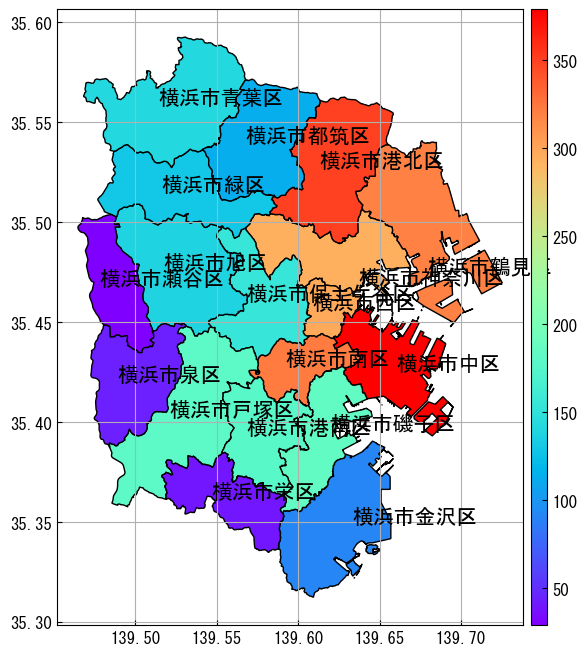

In [25]:
##### PLOT #####
fig, ax = plt.subplots(1, 1, figsize=(8, 8))


# gdf.plot
base = gdf.plot(ax=ax, color=num_color, edgecolor='black')  # 

# 市町村名をプロット
# Extract cordinates
name_df = gdf.groupby(['N03_003', 'N03_004'], dropna=False, as_index=False).mean().loc[:, ['N03_003', 'N03_004', 'x', 'y']]
name_df.drop(name_df[name_df['N03_004'].isna()].index)  # drop NaN
# Loop for the length of name_df
mylist = list(name_df.index)
for l in mylist:
    plt.text(name_df['x'][l]-0.01, name_df['y'][l], name_df['N03_004'][l], fontname="MS Gothic", fontsize=15)

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cax = fig.add_axes([base.get_position().x1+0.01, base.get_position().y0, 0.02, base.get_position().height])
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params()


#### Scatter plot

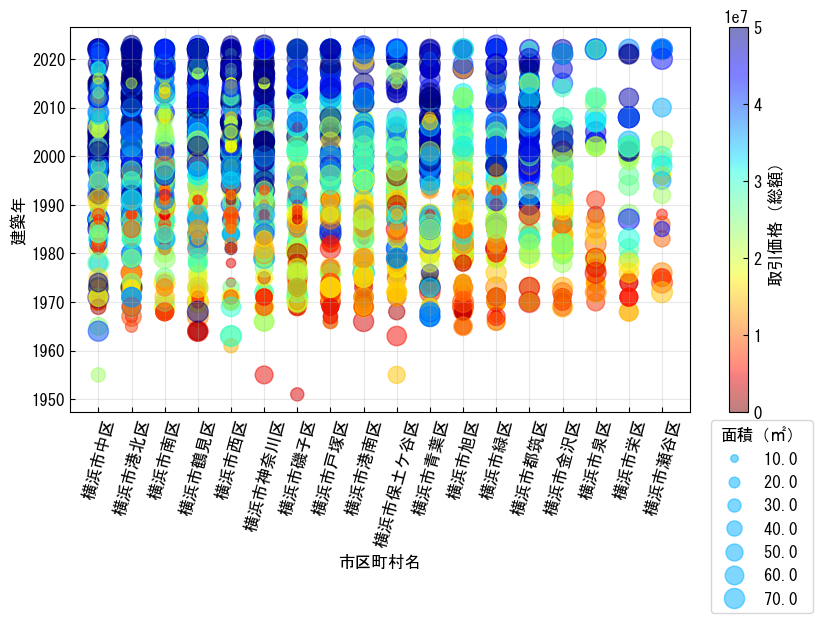

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
# scatter plot
x=df['市区町村名']
y=df['建築年']
c=df['取引価格（総額）']
s=df['面積（㎡）'] * 3
scatter = ax.scatter(x=x, y=y, c=c, s=s, cmap='jet_r', vmin=0, vmax=50_000_000, alpha=.5)

# settings
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.grid(True, alpha=.3)
plt.xticks(rotation=75)
# plot size
kw = dict(prop="sizes", num=5, color=scatter.cmap(0.7), fmt="{x} ", func=lambda s: s/3)  # https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
ax.legend(*scatter.legend_elements(**kw), bbox_to_anchor=(1.02, 0), loc="upper left", title=s.name)
# colorbar
plt.colorbar(scatter, label=c.name)

#### Bar Plot

In [28]:
df_bar = df[['市区町村名', '都市計画', '取引価格（総額）']]
df_bar

市区町村名          都市計画  取引価格（総額）
0      横浜市中区          商業地域  43000000
1      横浜市中区         準住居地域  42000000
2      横浜市中区       第１種住居地域  42000000
3      横浜市中区       第２種住居地域  41000000
4      横浜市中区       第１種住居地域  40000000
...      ...           ...       ...
3376  横浜市瀬谷区        近隣商業地域  36000000
3377  横浜市瀬谷区  第１種中高層住居専用地域  32000000
3378  横浜市瀬谷区        近隣商業地域  23000000
3379  横浜市瀬谷区       第１種住居地域  40000000
3380  横浜市瀬谷区   第１種低層住居専用地域  10000000

[3381 rows x 3 columns]

In [29]:
df_bar_grp = df_bar.groupby(['市区町村名', '都市計画']).sum().unstack()
df_bar_grp

取引価格（総額）                                                         \
都市計画            商業地域        工業地域    工業専用地域   市街化調整区域      準住居地域       準工業地域   
市区町村名                                                                         
横浜市中区     8421900000           0         0         0  205000000   362000000   
横浜市港北区    2096000000   253000000         0   8700000  275300000  2453400000   
横浜市南区     2693900000           0         0         0          0   276000000   
横浜市鶴見区    2338600000  1042000000         0         0  270700000  1959700000   
横浜市西区     7009400000           0         0         0   26000000   118000000   
横浜市神奈川区   2942500000   825000000  63000000    710000  226700000   127000000   
横浜市磯子区     939300000    28000000         0         0  201000000    70000000   
横浜市戸塚区     150000000   392000000         0  32100000  810200000   597300000   
横浜市港南区      52000000           0         0         0  316200000   315000000   
横浜市保土ケ谷区   110500000    50000000         0  16000000  319300000   121000000   
横浜市青葉区      29500000           0         0         0  936800000    47000000   
横浜市旭区       78000000           0         0   7000000  105500000   167700000   
横浜市緑区      267100000   160000000         0  28000000  540000000   226000000   
横浜市都筑区     770000000   409000000         0  46000000  311000000    83000000   
横浜市金沢区      94000000   107000000         0         0  102000000    36000000   
横浜市泉区              0           0         0   1560000   55000000   108000000   
横浜市栄区              0    68000000         0         0   37000000           0   
横浜市瀬谷区             0    50000000         0         0   77000000           0   

                                                                        \
都市計画     第１種中高層住居専用地域 第１種低層住居専用地域     第１種住居地域 第２種中高層住居専用地域 第２種低層住居専用地域   
市区町村名                                                                    
横浜市中区       409800000   163800000   897000000            0           0   
横浜市港北区      423000000  1130500000  2784600000    686100000    82000000   
横浜市南区        92400000   400000000  1585000000    268900000     4000000   
横浜市鶴見区              0   424800000  2047200000    979000000           0   
横浜市西区       120000000    17000000   356000000    502400000           0   
横浜市神奈川区     436000000   218700000  1791600000    974900000           0   
横浜市磯子区      598700000   395000000   551200000     87500000           0   
横浜市戸塚区      688300000   276500000   936800000    378800000           0   
横浜市港南区     1569300000   381400000   810500000    348000000           0   
横浜市保土ケ谷区    499300000   241500000   899200000    192000000           0   
横浜市青葉区     1180300000   856000000  1003000000    701000000    58000000   
横浜市旭区       871900000   347000000   628000000     68000000           0   
横浜市緑区       748000000   258101000   616200000     51000000           0   
横浜市都筑区      574300000   434000000   347000000    865000000           0   
横浜市金沢区      620000000   257100000   373500000            0           0   
横浜市泉区        87500000   346300000    42000000            0     9000000   
横浜市栄区        98700000   231900000   360000000     92000000           0   
横浜市瀬谷区       47100000   105600000   241800000            0           0   

                                 
都市計画        第２種住居地域      近隣商業地域  
市区町村名                            
横浜市中区     204000000   922900000  
横浜市港北区    153000000   797100000  
横浜市南区     113800000  1496300000  
横浜市鶴見区     39000000   378500000  
横浜市西区             0  1465300000  
横浜市神奈川区           0  1172700000  
横浜市磯子区    149800000   885550000  
横浜市戸塚区    104000000    67000000  
横浜市港南区     16000000   334900000  
横浜市保土ケ谷区   44000000   991200000  
横浜市青葉区    168000000   734000000  
横浜市旭区      37500000   104800000  
横浜市緑区      71000000   114000000  
横浜市都筑区     93000000   410000000  
横浜市金沢区     94500000   328600000  
横浜市泉区       9700000   136000000  
横浜市栄区      27000000   197000000  
横浜市瀬谷区     29000000   103000000

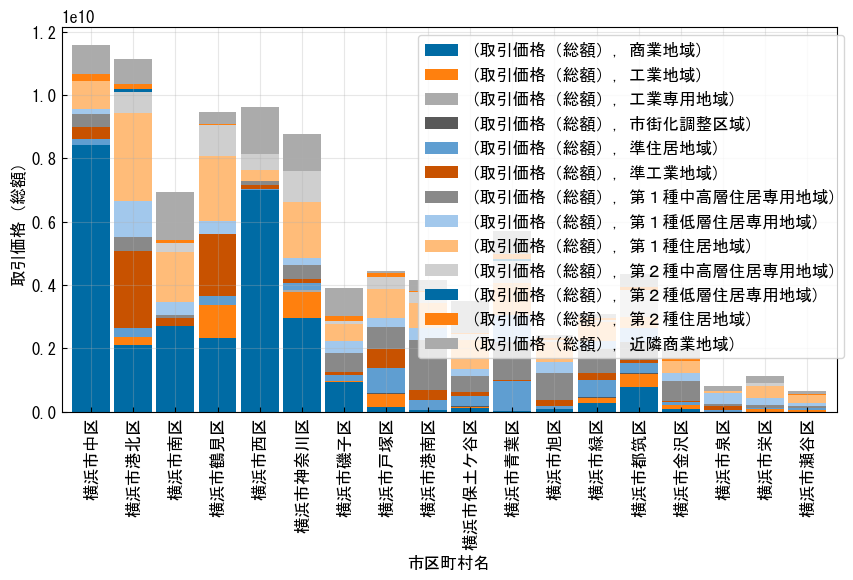

In [30]:
df_bar.groupby(['市区町村名', '都市計画']).sum().unstack().plot(kind='bar', stacked=True, figsize=(10,5), width=.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper right")
plt.xlabel(df_bar.columns[0])
plt.ylabel(df_bar.columns[-1])
plt.grid(True, alpha=.3)

#### 区単位

In [31]:
##### SETTINGS #####

# RealState data
filedir = r"C:\Users\A\Desktop\pythonProject\RealEstateProject\DATA\TXN HISTORY\kanagawa"
filedir_exp = filedir
filename = '14_Kanagawa Prefecture_20053_20224.csv'
datapath = filedir + '\\' + filename

In [32]:
##### DATA PROCESSING #####

# RealState data
df_raw = pd.read_csv(datapath, encoding="cp932")
# mask data
# 大阪市.*区
mask = df_raw[['市区町村名']].apply(lambda x: x.str.contains('横浜市西区')).any(axis=1)  # https://stackoverflow.com/questions/32614357/search-and-filter-pandas-dataframe-with-regular-expressions
df = df_raw[mask]
# str2int
df['取引時点'] = df['取引時点'].apply(str2int)
df['面積（㎡）'] = df['面積（㎡）'].apply(str2int)
# df['面積（㎡）'] < 80
df = df.loc[df['面積（㎡）'] < 80]
# wareki2western
df['建築年'] = df['建築年'].apply(wareki2western)  # wareki2western

㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
year is none of "令和" , "平成" and "昭和" 戦前
year is none of "令和" , "平成" and "昭和" 戦前
year is none of "令和" , "平成" and "昭和" 戦前
year is none of "令和" , "平成" and "昭和" 戦前
year is none of "令和" , "平成" and "昭和" 戦前


C:\Users\A\AppData\Local\Temp\ipykernel_1700\1656694429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['取引時点'] = df['取引時点'].apply(str2int)
C:\Users\A\AppData\Local\Temp\ipykernel_1700\1656694429.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['面積（㎡）'] = df['面積（㎡）'].apply(str2int)


Text(0, 0.5, '建築年')

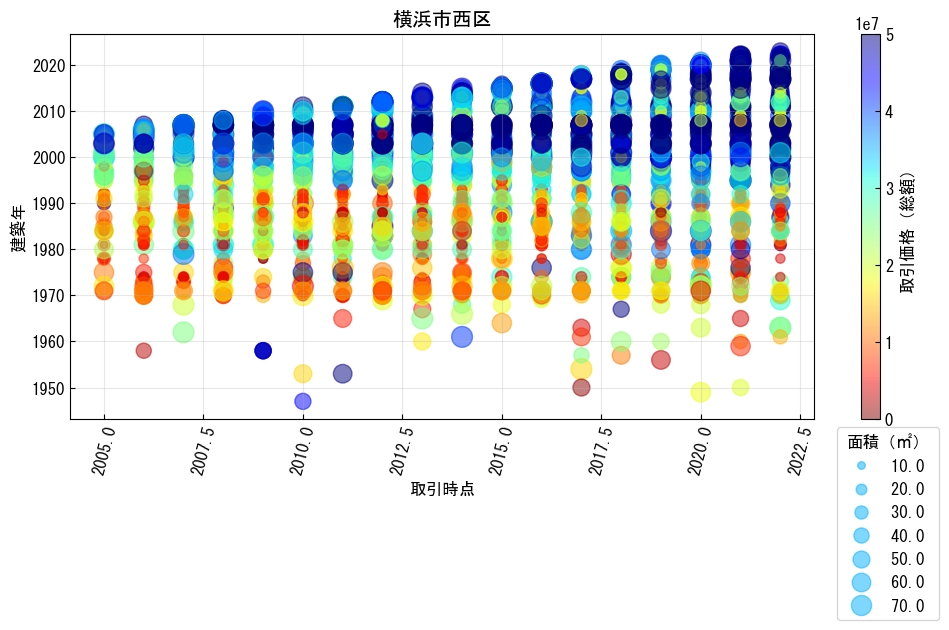

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.grid(True, alpha=.3)
plt.xticks(rotation=75)

# scatter plot
x=df['取引時点']
y=df['建築年']
c=df['取引価格（総額）']
s=df['面積（㎡）'] * 3
scatter = ax.scatter(x=x, y=y, c=c, s=s, cmap='jet_r', vmin=0, vmax=50_000_000, alpha=.5)

# plot size
kw = dict(prop="sizes", num=5, color=scatter.cmap(0.7), fmt="{x} ", func=lambda s: s/3)  # https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
ax.legend(*scatter.legend_elements(**kw), bbox_to_anchor=(1.02, 0), loc="upper left", title=s.name)
# colorbar
plt.colorbar(scatter, label=c.name)
# settings
plt.title(df['市区町村名'].iloc[0])
plt.xlabel(x.name)
plt.ylabel(y.name)

In [38]:
df_bar = df[['取引時点', '市区町村名', '都市計画', '取引価格（総額）']]
df_bar

取引時点  市区町村名     都市計画  取引価格（総額）
5859    2010  横浜市西区   近隣商業地域  17000000
5867    2010  横浜市西区  第１種住居地域  38000000
5877    2010  横浜市西区   近隣商業地域   3800000
5930    2010  横浜市西区   近隣商業地域  26000000
5932    2010  横浜市西区   近隣商業地域  16000000
...      ...    ...      ...       ...
160053  2005  横浜市西区      NaN  13000000
160057  2005  横浜市西区      NaN  11000000
160073  2006  横浜市西区      NaN  69000000
160076  2005  横浜市西区      NaN  64000000
160079  2005  横浜市西区      NaN  45000000

[4768 rows x 4 columns]

In [39]:
df_bar_grp = df_bar.groupby(['取引時点', '都市計画']).sum().unstack()
df_bar_grp

C:\Users\A\AppData\Local\Temp\ipykernel_1700\2447613595.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bar_grp = df_bar.groupby(['取引時点', '都市計画']).sum().unstack()


取引価格（総額）                                                    \
都市計画          商業地域        工業地域       準住居地域        準工業地域 第１種中高層住居専用地域   
取引時点                                                                   
2005  2.800000e+06         NaN         NaN          NaN          NaN   
2006  6.545000e+08         NaN  12000000.0          NaN          NaN   
2007  1.905800e+09         NaN  18000000.0  161000000.0   14400000.0   
2008  4.014100e+09         NaN         NaN  164900000.0          NaN   
2009  3.827450e+09         NaN         NaN  128000000.0   70300000.0   
2010  4.863200e+09         NaN         NaN   99000000.0   33000000.0   
2011  3.667600e+09  34000000.0         NaN   63000000.0   32700000.0   
2012  5.085000e+09         NaN         NaN   27000000.0   19000000.0   
2013  4.661500e+09  32000000.0         NaN    7500000.0   13000000.0   
2014  5.078200e+09         NaN         NaN   49000000.0   59000000.0   
2015  4.793700e+09         NaN         NaN  117000000.0   22000000.0   
2016  4.948700e+09         NaN         NaN   94000000.0   26100000.0   
2017  5.319000e+09         NaN  67000000.0   84000000.0          NaN   
2018  6.226700e+09         NaN         NaN  159000000.0   52000000.0   
2019  5.429100e+09         NaN  16000000.0  122000000.0  172500000.0   
2020  7.492600e+09         NaN  43000000.0  139000000.0   63000000.0   
2021  7.712500e+09         NaN         NaN   90000000.0   27000000.0   
2022  7.009400e+09         NaN  26000000.0  118000000.0  120000000.0   

                                                                       
都市計画 第１種低層住居専用地域       第１種住居地域 第２種中高層住居専用地域     第２種住居地域        近隣商業地域  
取引時点                                                                   
2005         NaN           NaN  114000000.0         NaN  1.460000e+08  
2006         NaN  2.460000e+07  261700000.0         NaN  1.535000e+08  
2007  78300000.0  3.756000e+08  331300000.0         NaN  3.806000e+08  
2008  11800000.0  4.177000e+08  432300000.0         NaN  3.768000e+08  
2009    700000.0  3.962000e+08  466200000.0         NaN  1.411100e+09  
2010   1500000.0  5.353000e+08  140800000.0         NaN  8.668000e+08  
2011   3800000.0  3.243100e+08  312500000.0         NaN  4.899000e+08  
2012  39800000.0  3.758000e+08  779200000.0         NaN  1.065000e+09  
2013  94000000.0  6.404000e+08  566800000.0         NaN  1.027400e+09  
2014  12400000.0  3.299000e+08  641100000.0         NaN  6.387000e+08  
2015         NaN  5.524000e+08  400600000.0  55000000.0  1.187500e+09  
2016  20100000.0  3.128000e+08  835700000.0  77000000.0  7.998000e+08  
2017         NaN  3.680000e+08  496080000.0  70000000.0  1.276300e+09  
2018  11200000.0  4.861000e+08  465700000.0         NaN  1.173300e+09  
2019  35800000.0  5.955000e+08  605100000.0         NaN  1.003800e+09  
2020         NaN  9.172000e+08  866600000.0  18000000.0  1.865000e+09  
2021  29500000.0  1.114600e+09  951000000.0  43000000.0  1.317500e+09  
2022  17000000.0  3.560000e+08  502400000.0         NaN  1.465300e+09

C:\Users\A\AppData\Local\Temp\ipykernel_1700\771832269.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bar.groupby(['取引時点', '都市計画']).sum().unstack().plot(kind='bar', stacked=True, figsize=(10,5), width=.9)


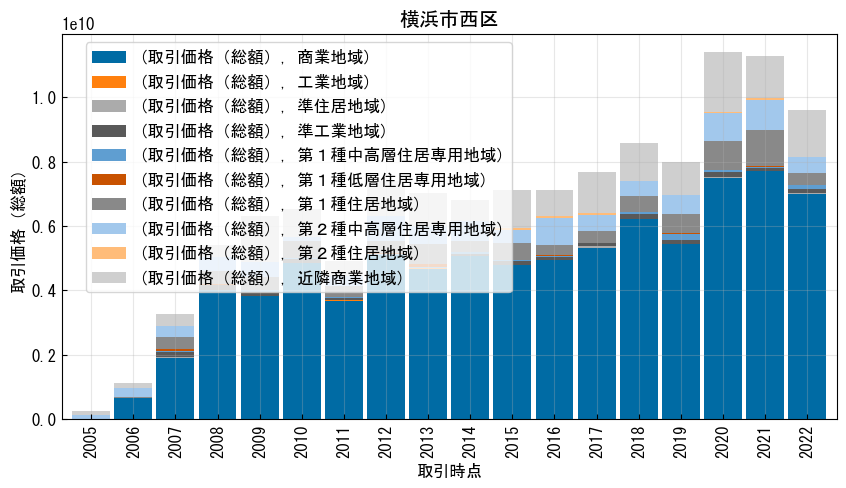

In [43]:
df_bar.groupby(['取引時点', '都市計画']).sum().unstack().plot(kind='bar', stacked=True, figsize=(10,5), width=.9)
plt.legend(bbox_to_anchor=(0.02, 1), loc="upper left")
plt.title(df_bar['市区町村名'].iloc[0])
plt.xlabel(df_bar.columns[0])
plt.ylabel(df_bar.columns[-1])
plt.grid(True, alpha=.3)

C:\Users\A\AppData\Local\Temp\ipykernel_1700\1385691814.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bar2.groupby(['取引時点', '都市計画']).mean().unstack().plot(ax=ax)


Text(0, 0.5, '取引価格（総額）')

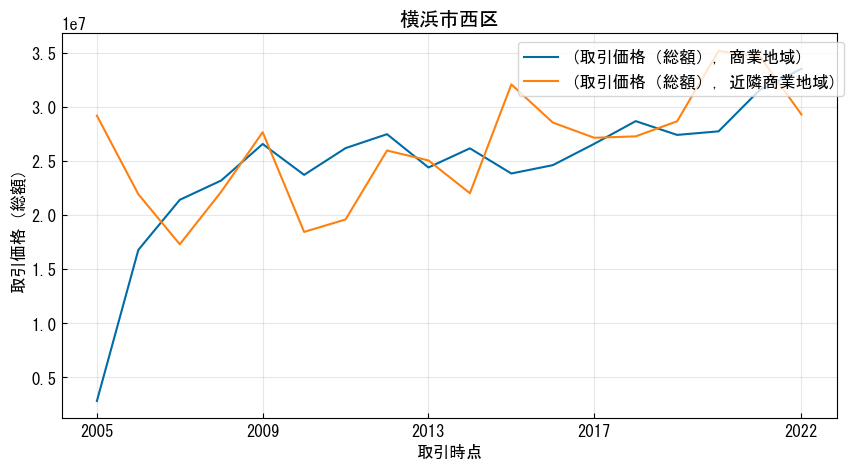

In [42]:
# 商業地域
mask = df_bar[['都市計画']].apply(lambda x: x.str.contains('商業地域')).any(axis=1)  # https://stackoverflow.com/questions/32614357/search-and-filter-pandas-dataframe-with-regular-expressions
df_bar2 = df_bar[mask]
# PLOT
fig, ax = plt.subplots(figsize=(10,5))
df_bar2.groupby(['取引時点', '都市計画']).mean().unstack().plot(ax=ax)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper right")
# SET UP
ax.set_xticks(np.linspace(df_bar['取引時点'].min(), df_bar['取引時点'].max(), 5).astype(int))
ax.grid(True, alpha=.3)
plt.title(df_bar['市区町村名'].iloc[0])
plt.xlabel(df_bar.columns[0])
plt.ylabel(df_bar.columns[-1])

In [44]:
##### DATA PROCESSING #####

# RealState data
df_raw = pd.read_csv(datapath, encoding="cp932")
df = df_raw[['取引時点', '市区町村名', '都市計画', '面積（㎡）', '取引価格（総額）']]
# MASK 0: 商業地域
mask = df[['都市計画']].apply(lambda x: x.str.contains('商業地域')).any(axis=1)
df = df[mask]
# MASK 1: 面積（㎡）
df['面積（㎡）'] = df['面積（㎡）'].apply(str2int)
mask = df[['面積（㎡）']].apply(lambda x: x<35).any(axis=1)
df = df[mask]
# MASK 2: 市区町村名
s = '横浜市中区|横浜市西区|横浜市南区|横浜市神奈川区|横浜市鶴見区|横浜市保土谷|横浜市戸塚区'
mask = df[['市区町村名']].apply(lambda x: x.str.contains(s, regex=True)).any(axis=1)
df = df[mask]
df = df[['取引時点', '市区町村名', '都市計画', '取引価格（総額）']]
# str2int
df['取引時点'] = df.loc[:, '取引時点'].apply(str2int)

㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000
㎡以上: 2000


In [45]:
df

取引時点   市区町村名    都市計画  取引価格（総額）
33      2010  横浜市鶴見区    商業地域   5000000
34      2010  横浜市鶴見区    商業地域   5800000
283     2010  横浜市鶴見区  近隣商業地域   3400000
371     2010  横浜市鶴見区    商業地域   6200000
372     2010  横浜市鶴見区    商業地域   6500000
...      ...     ...     ...       ...
182813  2007   横浜市南区    商業地域  14000000
236467  2008  横浜市戸塚区    商業地域   6800000
236479  2008  横浜市戸塚区    商業地域   6800000
236553  2008  横浜市戸塚区    商業地域   7400000
246230  2005  横浜市戸塚区  近隣商業地域   9100000

[7583 rows x 4 columns]

Text(0, 0.5, '取引価格（総額）')

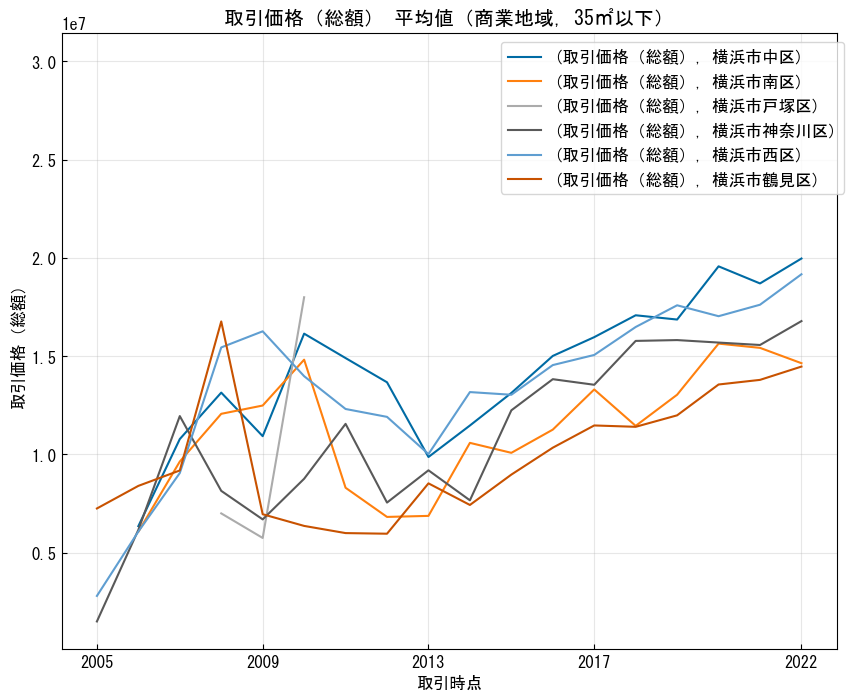

In [46]:
fig, ax = plt.subplots(figsize=(10,8))

# PLOT
df.groupby(['取引時点', '市区町村名']).mean(numeric_only=True).unstack().plot(ax=ax)
    
# SET UP
ax.set_xticks(np.linspace(df['取引時点'].min(), df['取引時点'].max(), 5).astype(int))
ax.grid(True, alpha=.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper right")
plt.title(df.columns[-1]+' 平均値（商業地域, 35㎡以下）')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[-1])

### END